# Tutorial 3 - Working with scanpy

## Load required packages

In [2]:
# Load necessary packages as we did in week 1 using the import and from commands
#
# Jupyter notebooks have so called "magic" functions that lets us interact
# with packages in a command line like format. 
# %matplotlib inline directs the output of plotting commands to appear directly
# below the cell that produced it.
#
# As academic software in paticular is constantly evolving, some of the tools
# that packages rely on can update at different speeds. If certain commands are
# scheduled to be phased out, they often warn users with a "FutureWarning"
# The last line silences these warnings, to avoid distraction.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import csv
import scanpy as sc
import copy
import re
import louvain
from collections import Counter
from igraph import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Set the present working directory with the getcwd() function from the os library
pwd = os.getcwd()

In [4]:
# Check this is set correctly to '/home/<SUNetID>/BIOC281/Classes/3'
pwd

'/home/ktrav/BIOC281/Classes/3'

## Data and metadata ingest

In [81]:
# See https://scanpy.readthedocs.io/en/stable/api/index.html#reading
# for examples on how to read other file types
# The path.join() command from the os library works similar to here() in R
# sc.read_csv() expects cells to be rows, so .T transposes the object
adata = sc.read_csv(filename=os.path.join(pwd, 'krasnow_hlca_10x_UMIs.csv')).T
adata = adata[adata.obs_names.sort_values()]

In [82]:
# Read in the meta.data using read_csv() from pandas, like in the first tutorial
# adata is an AnnData object (https://anndata.readthedocs.io/en/latest/)
# It is similar to a Seurat object in that it stores important information in different shelves
# You can access them with a "." symbol followed by their name.
# In this case, the AnnData expects the "obs" shelf to contain the cellular metadata
tmp = pd.read_csv(filepath_or_buffer=os.path.join(pwd, 'krasnow_hlca_10x_metadata.csv'), index_col=0).sort_index()
adata.obs = tmp.copy()

In [83]:
# Subset the dataset to include only data from patient 1
# Recall from the first tutorial that columns from pandas dataframes (called pandas series)
# can be accessed using a "." symbol followed by their column name
adata = adata[adata.obs.patient == 1]

In [84]:
# Write the adata object to an h5ad file to ease import, also seems to halve the memory usage
# h5ad is a special binary file format that extends python's hd5f format (https://www.h5py.org)
adata.write(os.path.join(pwd, 'krasnow_hlca_10x_raw.h5ad'))

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'channel' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'free_annotation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'location' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'magnetic.selection' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'preparation.site' as categorical
Trying to set attribute 

In [4]:
# Uncomment and execute if you need to read in the object again
# Useful as sc.read_csv is slow
#adata = sc.read_h5ad(filename = os.path.join(pwd, 'krasnow_hlca_10x_raw.h5ad'))

In [85]:
# Keep a copy for subclustering later
# There is an important difference between R and Python in how they save equivalent variables
# In Python, if you set a = [1, 2], then set b = a, and then set b[1] = 10, a[1] will also equal 10
# In R, if you set a = c(1,2), then set b = a, then set b[1] = 10, a[1] will NOT equal 10
# Copying variables as below allows us to copy the adata object and break the linkage between them
# We use deepcopy from the copy library as adata is a multilevel, complex object as we will explore
adata_raw = copy.deepcopy(adata)

In [6]:
# Uncomment and execute if you need to reset the object
# Useful as sc.read_csv is slow
#adata = copy.deepcopy(adata_raw)

## Explore the scanpy object

In [6]:
# Show the basic contents of adata
adata

AnnData object with n_obs × n_vars = 9744 × 26485
    obs: 'nGene', 'nUMI', 'orig.ident', 'channel', 'tissue', 'region', 'percent.ribo', 'free_annotation', 'patient', 'sample', 'location', 'magnetic.selection', 'preparation.site', 'compartment', 'prolif.score', 'MPP.score', 'HSC.score', 'gen.egress.score', 'lymphocyte.egress.score', 'myeloid.egress.score'

In [13]:
# As noted above, the obs self in the AnnData object holds the cellular metadata
# The first five rows and columns can be accessed using the iloc() function from pandas
# In python, the "0" preceeding the ":" symbol is assumed and can be omitted
adata.obs.iloc[:5,:5]

nGene  nUMI                  orig.ident channel tissue
P1_1_AAACCTGAGCGATAGC    959  3583  Human Lung 10x - Patient 1    P1_1  blood
P1_1_AAACGGGTCATCGATG   1149  2914  Human Lung 10x - Patient 1    P1_1  blood
P1_1_AACACGTTCGTTTAGG   1159  3100  Human Lung 10x - Patient 1    P1_1  blood
P1_1_AACTCAGAGCGGCTTC    755  2267  Human Lung 10x - Patient 1    P1_1  blood
P1_1_AACTCCCAGGGCATGT   1112  3212  Human Lung 10x - Patient 1    P1_1  blood

In [31]:
# Specific columns from metadata can be accessed by name using a "." symbol
# We then select the first five cells
adata.obs.nGene[:5]

P1_1_AAACCTGAGCGATAGC     959
P1_1_AAACGGGTCATCGATG    1149
P1_1_AACACGTTCGTTTAGG    1159
P1_1_AACTCAGAGCGGCTTC     755
P1_1_AACTCCCAGGGCATGT    1112
Name: nGene, dtype: int64

In [30]:
# Specific cells can also be accessed by subsetting the whole adata object
adata[['P1_1_AAACCTGAGCGATAGC', 'P1_1_AACTCCCAGGGCATGT']].obs

nGene  nUMI                  orig.ident channel tissue  \
P1_1_AAACCTGAGCGATAGC    959  3583  Human Lung 10x - Patient 1    P1_1  blood   
P1_1_AACTCCCAGGGCATGT   1112  3212  Human Lung 10x - Patient 1    P1_1  blood   

                       region  percent.ribo         free_annotation  patient  \
P1_1_AAACCTGAGCGATAGC  normal      0.500977  CD4+ Memory/Effector T        1   
P1_1_AACTCCCAGGGCATGT  normal      0.337796  CD4+ Memory/Effector T        1   

                        sample  ... preparation.site compartment prolif.score  \
P1_1_AAACCTGAGCGATAGC  blood 1  ...           biohub      Immune    -1.253383   
P1_1_AACTCCCAGGGCATGT  blood 1  ...           biohub      Immune    -1.253383   

                      MPP.score  HSC.score  gen.egress.score  \
P1_1_AAACCTGAGCGATAGC -0.887927  -2.778003         -2.387315   
P1_1_AACTCCCAGGGCATGT -0.887927  -0.828142         -2.387315   

                       lymphocyte.egress.score  myeloid.egress.score  leiden  \
P1_1_AAACCTGAGCGATAGC                -2.795320             -3.922822       4   
P1_1_AACTCCCAGGGCATGT                -4.299489             -3.922822       4   

                       louvain  
P1_1_AAACCTGAGCGATAGC        5  
P1_1_AACTCCCAGGGCATGT        5  

[2 rows x 22 columns]

In [9]:
# The UMI/counts matrix starts in the "X" shelf of the adata object
# As you proceed through data normalization and scaling, scanpy automatically changes X
# Each column is a cell with genes as rows
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# Specific genes can be referenced from the "X" shelf, the first 5 cells are shown
# adata objects can be subset by [rows, columns] much like R data frames
adata[:5, ['ACTB', 'UBB']].X

ArrayView([[13.,  2.],
           [14.,  3.],
           [40.,  3.],
           [18.,  0.],
           [39.,  2.]], dtype=float32)

In [11]:
# scanpy updates the X layer as we normalize and scale the data, so we need to save the
# original UMIs somewhere else. The standard place to store additional expression matrices
# with the same dimensions as X is the "layers" shelf. As noted above, when we equate variables
# in python they remain linked unless we copy them.
adata.layers['UMIs'] = adata.X.copy()

## Basic quality control

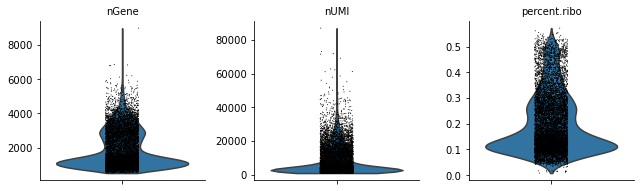

In [16]:
# Set the dimensions for the figures plotted by the code below
plt.rcParams['figure.figsize'] = [12, 6]

# The violin() function in scanpy's plotting library (pl) allows us to plot comtinuous
# variables similar to Seurat. Many of the functions in scanpy's preproccing (pp) and
# tools (tl) libraries have corresponding plotting functions as we will see below
sc.pl.violin(adata, keys=['nGene', 'nUMI', 'percent.ribo'], multi_panel=True)

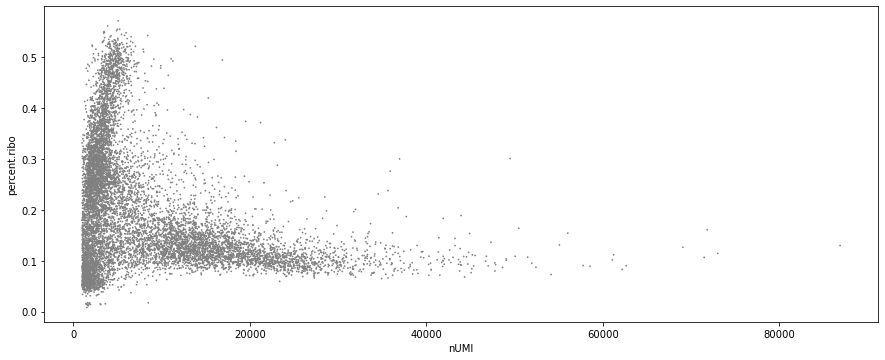

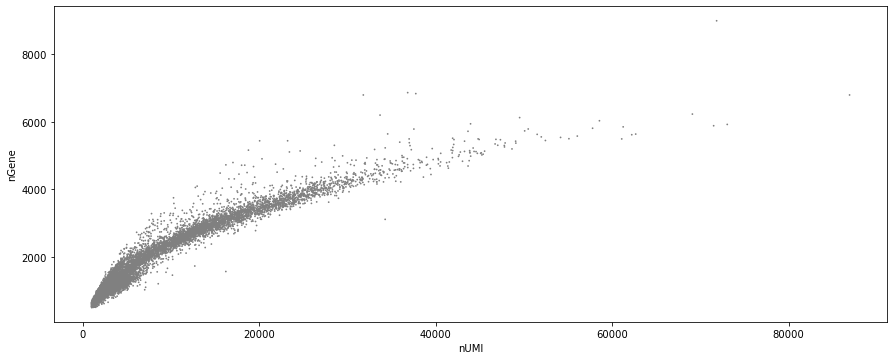

In [17]:
plt.rcParams['figure.figsize'] = [12, 6]

# The scatter() function in scanpy's plotting library (pl) allows us to plot two continuous
# variables against one another
sc.pl.scatter(adata, x='nUMI', y='percent.ribo')
sc.pl.scatter(adata, x='nUMI', y='nGene')

In [86]:
# Subset the data to include only cells with greater than 500 genes and 1000 UMIs detected
# In python, if numbers are omitted around a ":" symbol the range is assumed to include all values
adata = adata[adata.obs.nGene > 500, :]
adata = adata[adata.obs.nUMI > 1000, :]

In [19]:
# Copy the adata object for complex normalizations with scVI and MAGIC later on
# Both assume adata.X is are unnormalized UMIs
adata_scvi = copy.deepcopy(adata)
adata_magic = copy.deepcopy(adata)

## Basic data normalization

In [87]:
# Convert UMIs to UMIs per 10K and then take the natural log of all values plus 1
# This updates the X shelf in the AnnData object, which is why we stashed the UMIs
# in adata.layers['UMIs']. Function is similar to Seurat's NormalizeData() function
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [88]:
# Many of scanpy's internal functions assume adata.raw.X contains the normalized expression values,
# while adata.X contains the centered and scaled z-scores (set after sc.pp.scale is run below)
#
# Copy adata to adata.raw to preserve the normalized expression values
adata.raw = adata

In [22]:
# Copy the adata object for complex normalizations with sam later
# SAM assumes that adata.X are normalized expression values
adata_sam = copy.deepcopy(adata)

## Feature selection

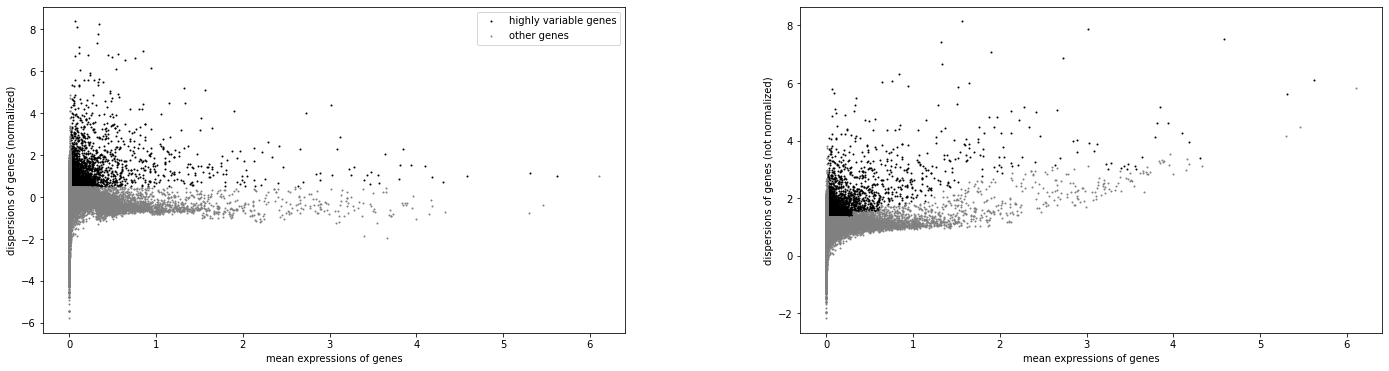

In [89]:
plt.rcParams['figure.figsize'] = [12, 6]

# Select and plot genes that have high dispersion (>0.5) and mean expression (>0.0125)
# This selection is similar to "mean.var.plot" feature selection called with
# the FindVariableFeatures function in Seurat
# Note how the highly_variable_genes() function in scanpy's preprocessing (pp) library
# has a matching function with its plotting (pl) library
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

## Linear dimensionality reduction

In [90]:
# Center and scale the expression values in adata.X, making them z-scores
sc.pp.scale(adata, max_value=10)
# Run principle component analysis
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

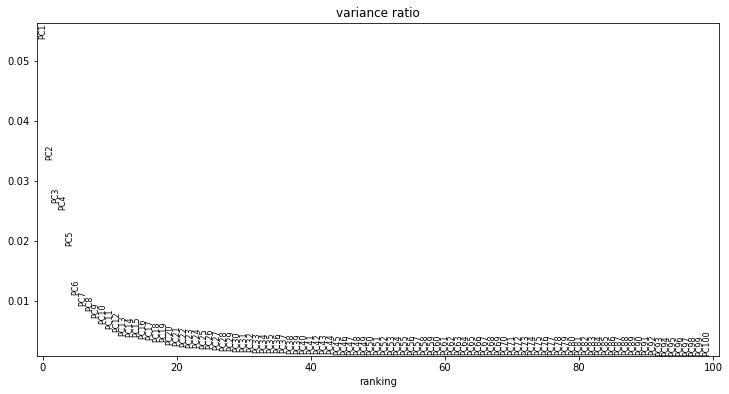

In [36]:
plt.rcParams['figure.figsize'] = [12, 6]

# Plot the variance explained by each principle compnent
# Similar to ElbowPlot() function in Seurat
sc.pl.pca_variance_ratio(adata, n_pcs=100)

PC = 1


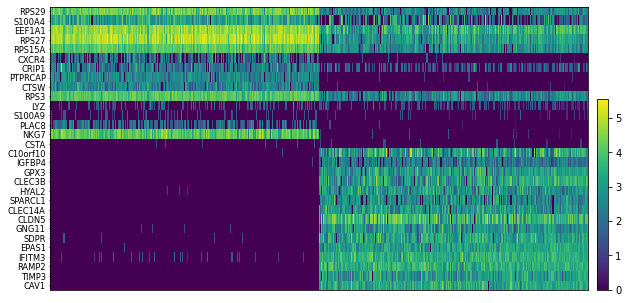

PC = 2


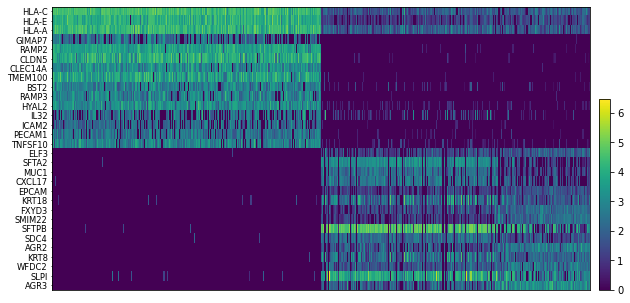

PC = 3


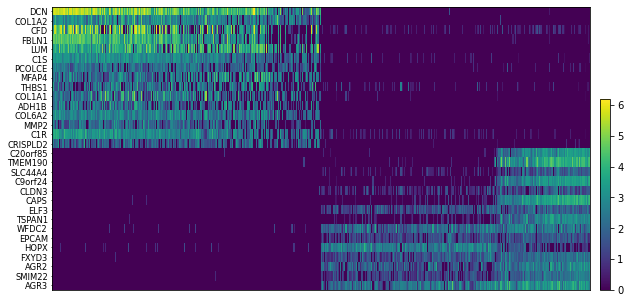

PC = 4


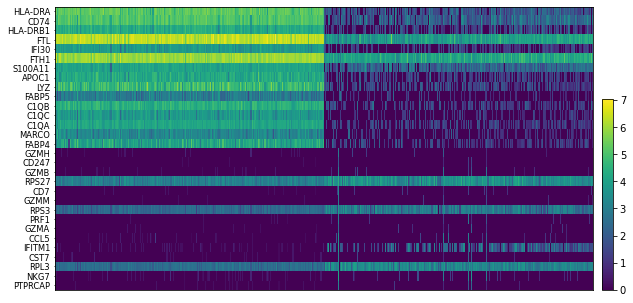

PC = 5


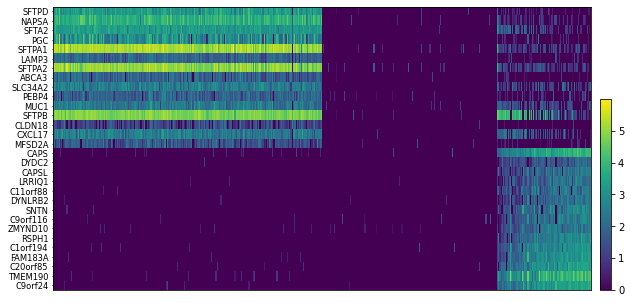

PC = 6


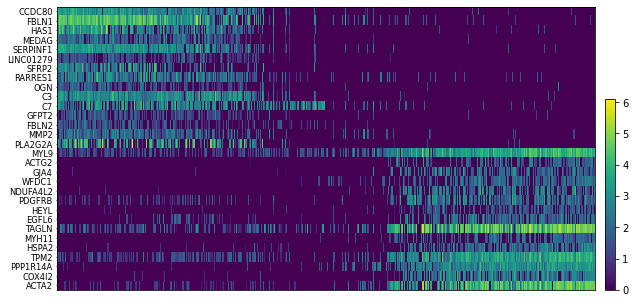

PC = 7


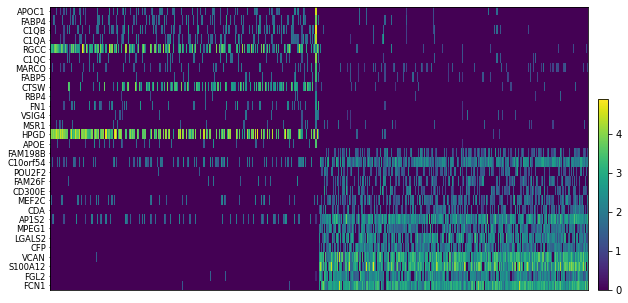

PC = 8


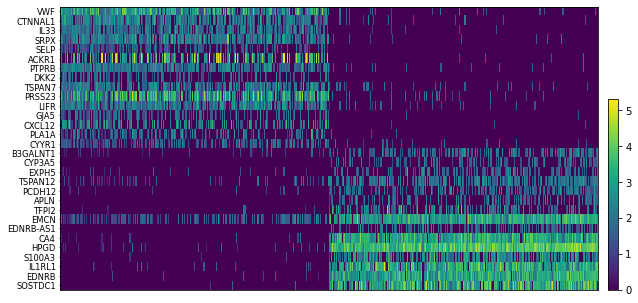

PC = 9


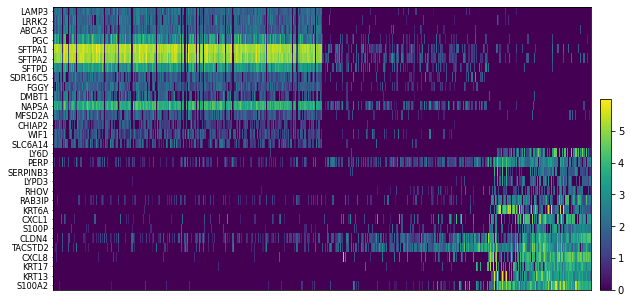

PC = 10


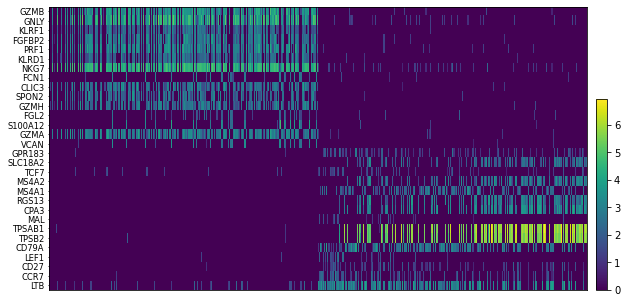

PC = 11


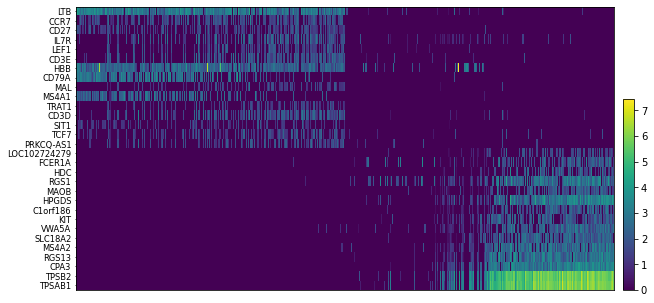

PC = 12


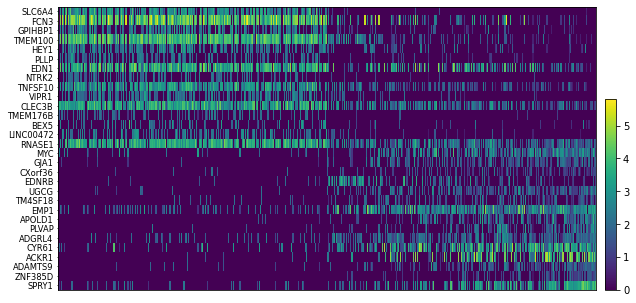

PC = 13


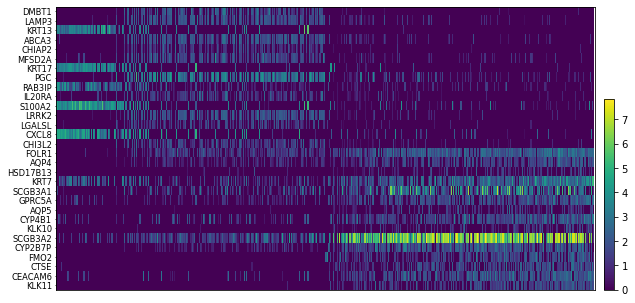

PC = 14


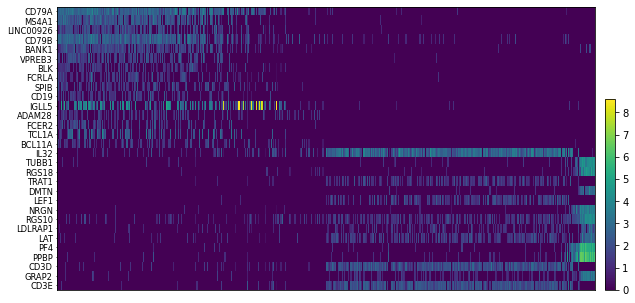

PC = 15


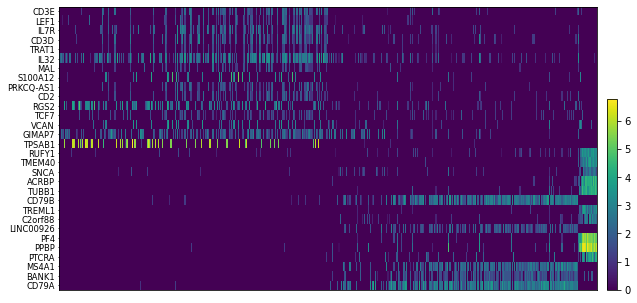

PC = 16


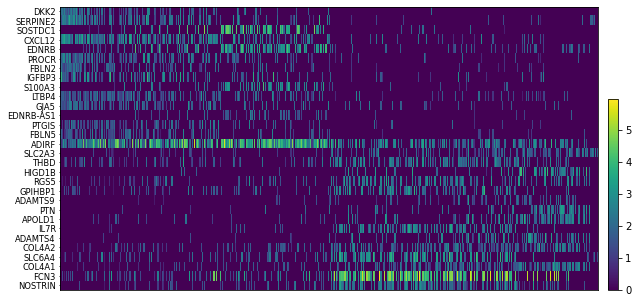

PC = 17


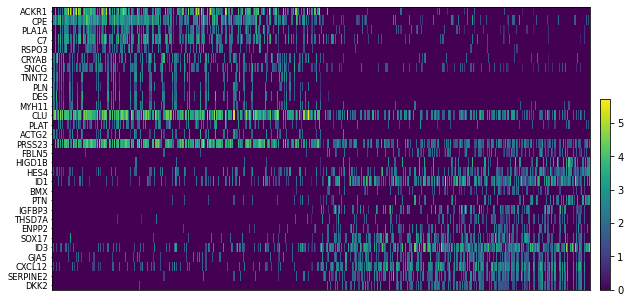

PC = 18


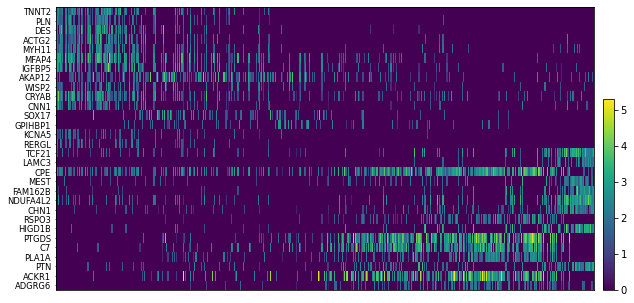

PC = 19


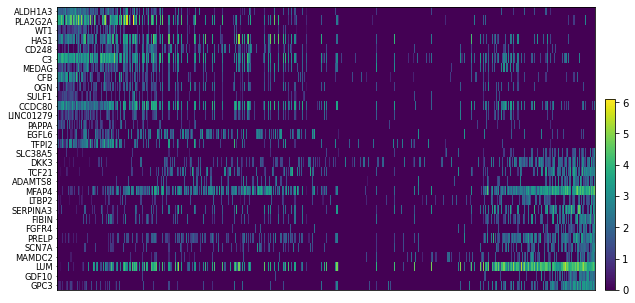

PC = 20


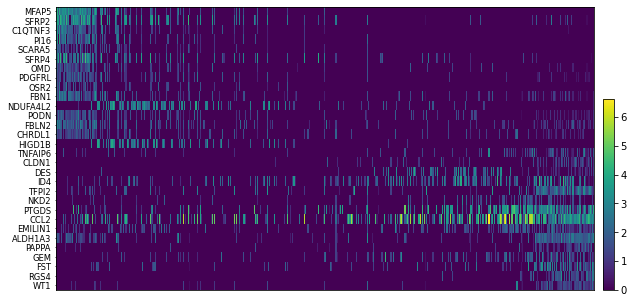

PC = 21


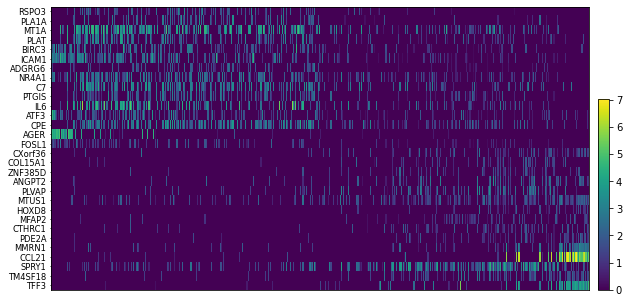

PC = 22


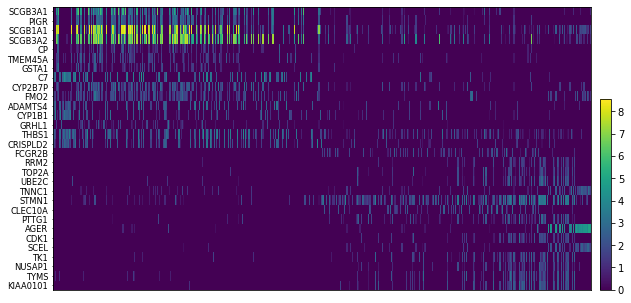

PC = 23


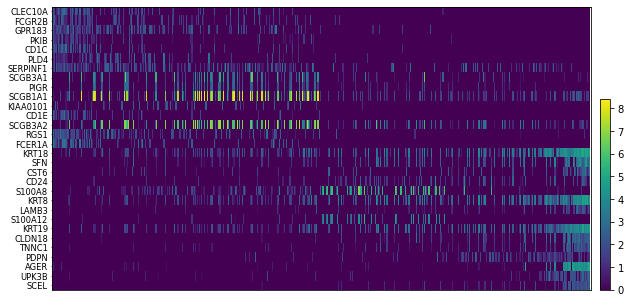

PC = 24


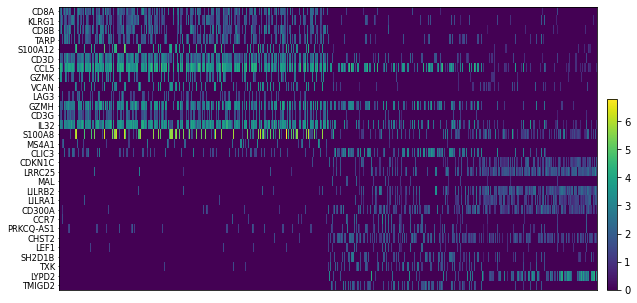

PC = 25


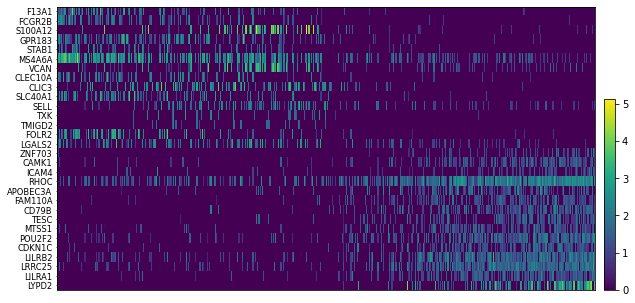

PC = 26


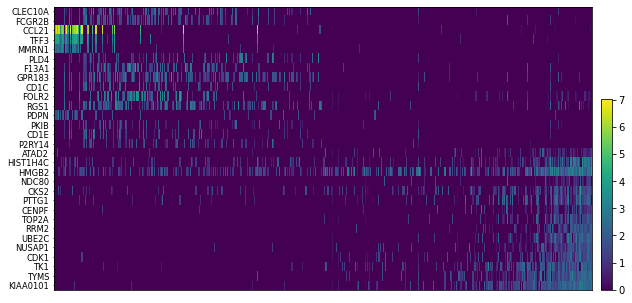

PC = 27


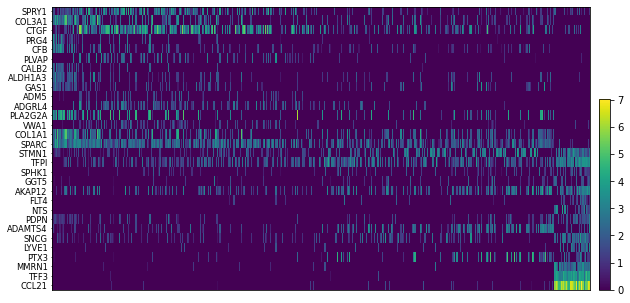

PC = 28


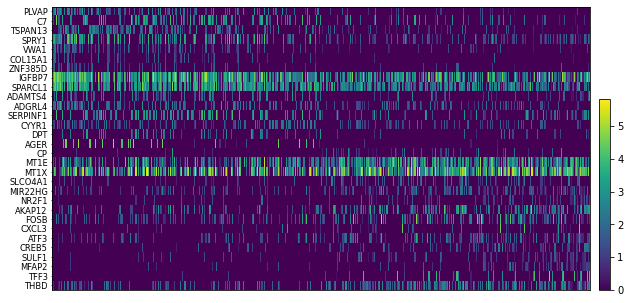

PC = 29


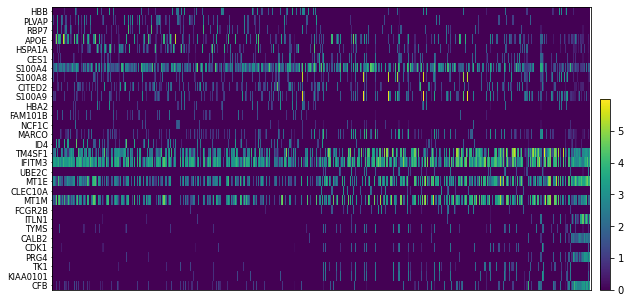

PC = 30


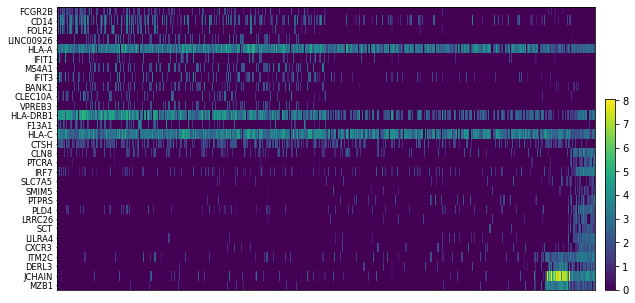

PC = 31


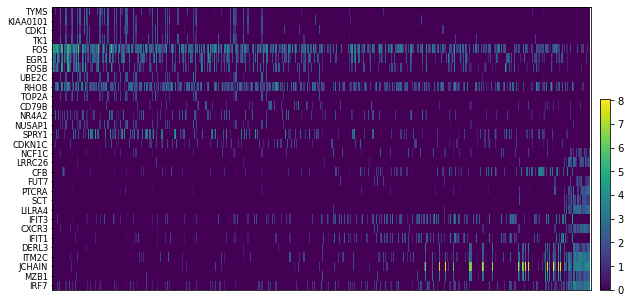

PC = 32


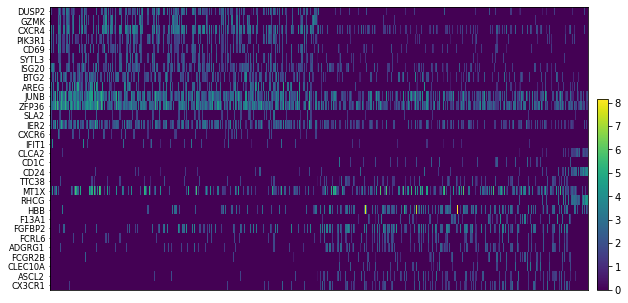

PC = 33


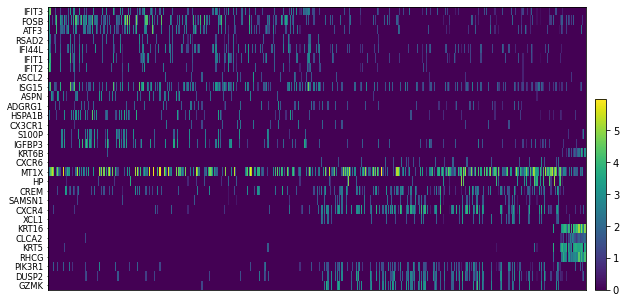

PC = 34


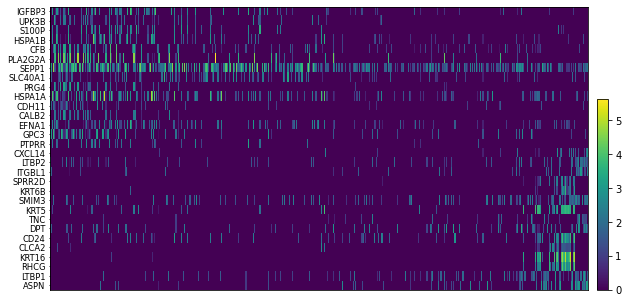

PC = 35


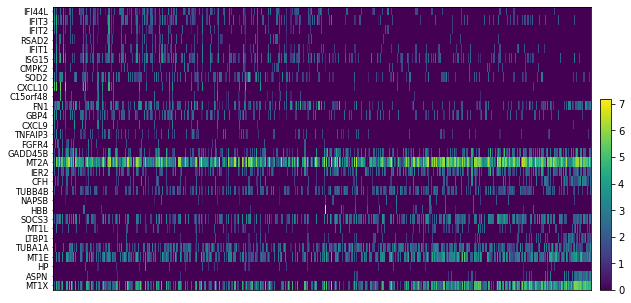

PC = 36


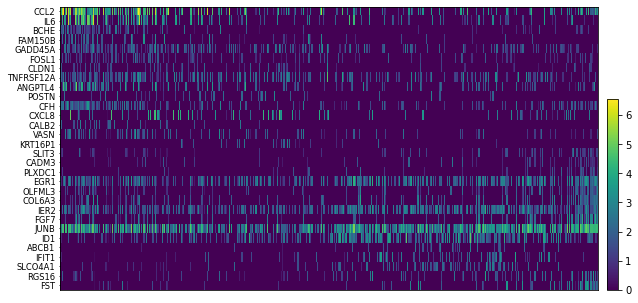

PC = 37


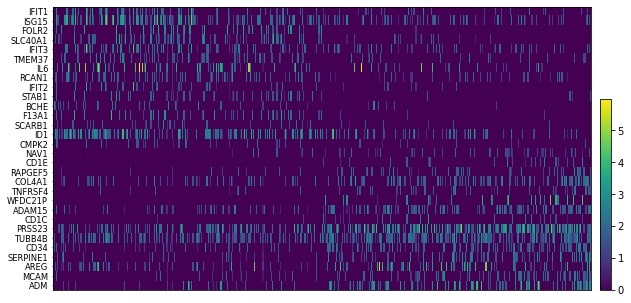

PC = 38


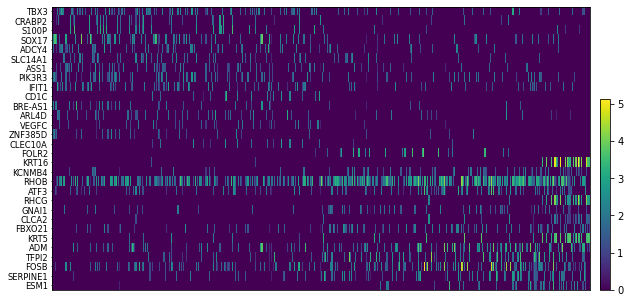

PC = 39


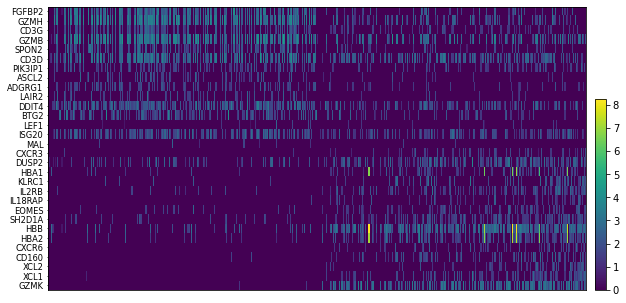

PC = 40


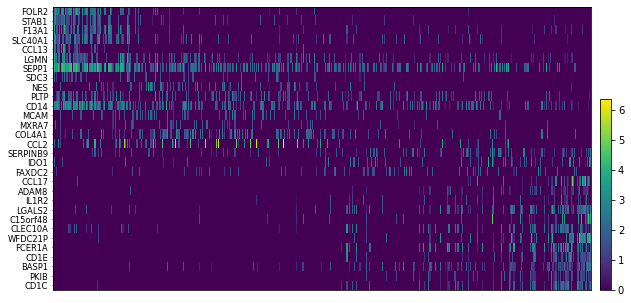

PC = 41


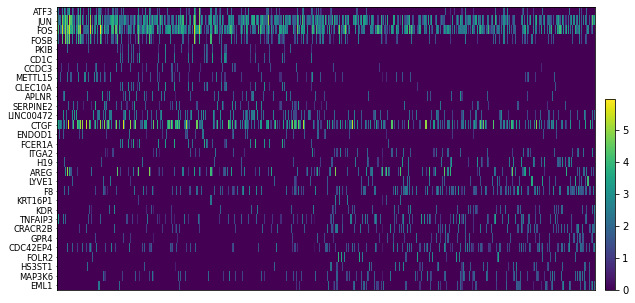

PC = 42


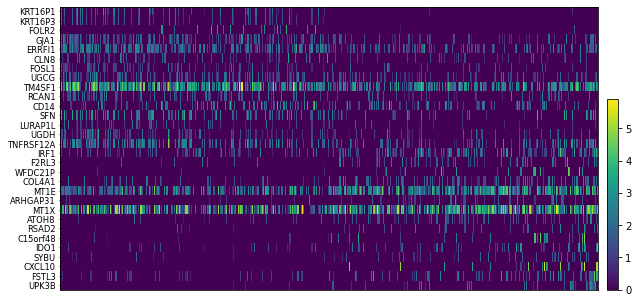

PC = 43


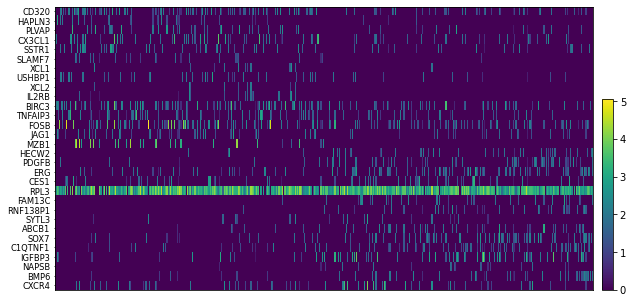

PC = 44


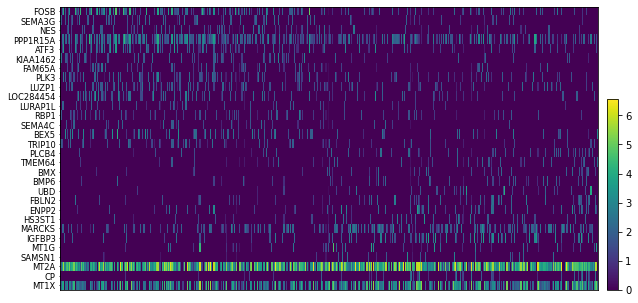

PC = 45


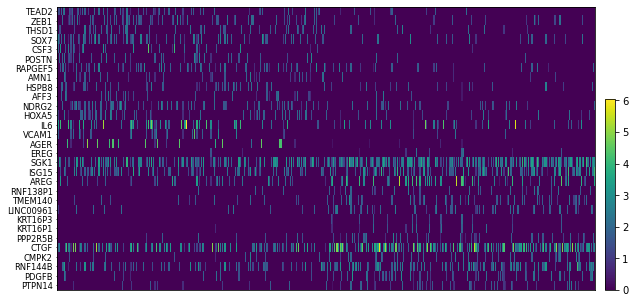

PC = 46


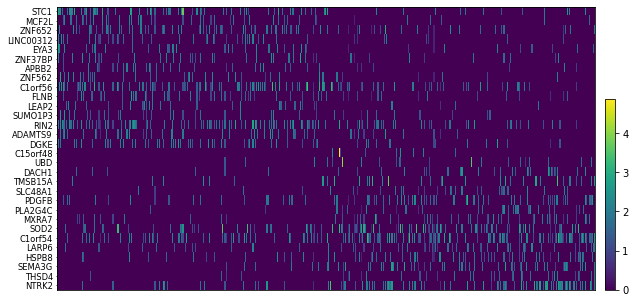

PC = 47


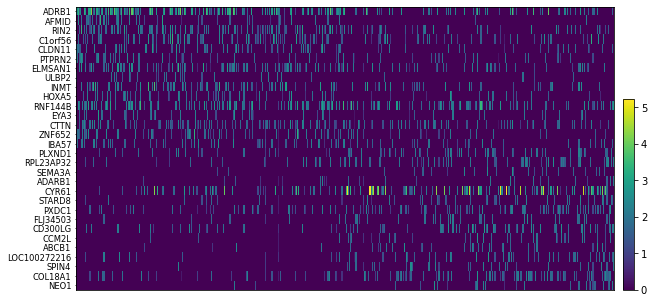

PC = 48


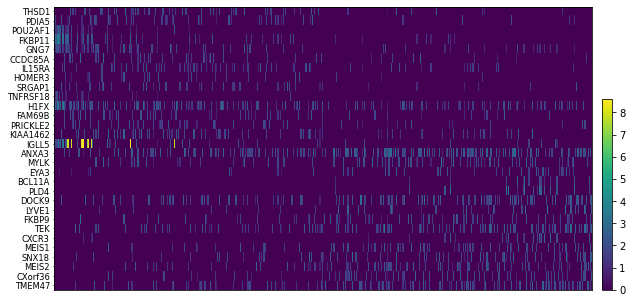

PC = 49


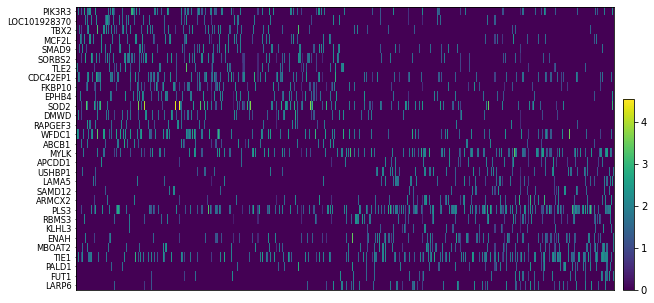

PC = 50


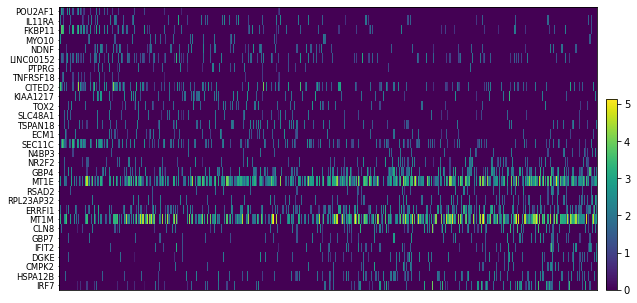

In [37]:
plt.rcParams['figure.figsize'] = [12, 50]

# Plot expression of the top and bottom 15 genes (based on loading) in each principle component
# from the 500 cells with the highest or lowest scores in that component
# Similar to Seurat's DimHeatmap() command
genes = adata.var_names.to_series()
for pc in range(1,51):
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:15],o[-15:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    cells = np.append(np.argsort(emb)[:250], np.argsort(emb)[-250:])
    tempdata = adata[cells,]
    print('PC = ' + str(pc))
    sc.pl.heatmap(tempdata, var_names=genes[sel].index.tolist(), swap_axes=True, groupby=None)

## First round of clustering on the whole dataset

In [91]:
# Calculate the nearest neighbor map from the first 50 principle components 
# with k=10 nearest neighbors. These settings are identical to what we
# found was "optimal" in Seurat.
#
# scanpy does not perform pruning on its nearest neighbor network like Seurat
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

# Cluster the cells using the nearest neighbor graph with the leiden and louvain
# algorithms and a resolution of 0.5 (again identical to the "optimal" paramters from Seurat)
# The output of both are stored in "obs" shelf of adata, under the columns "leiden" and "louvain"
sc.tl.leiden(adata, resolution=0.5)
sc.tl.louvain(adata, resolution=0.5)

## Calculate two dimensional coordinates for all cells with UMAP

In [92]:
# Calculate UMAP coordinates using the nearest neighbor map calculated above
# scanpy uses the same dimensions as the neighbors() function from scanpy's
# preprocessing (pp) library
sc.tl.umap(adata)

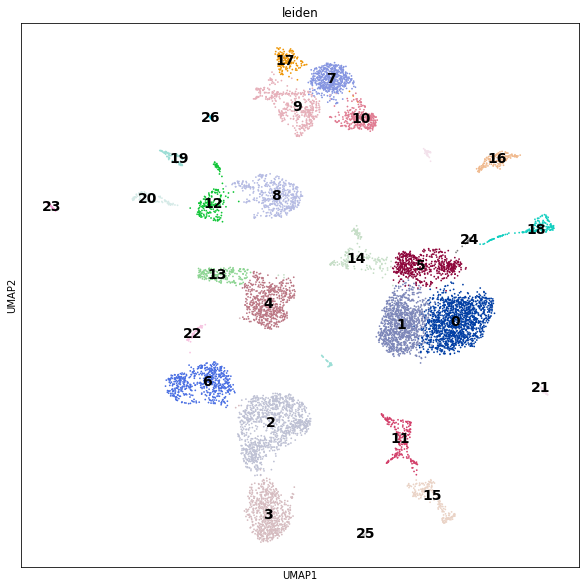

In [94]:
plt.rcParams['figure.figsize'] = [10, 10]

# Plot the UMAP coordinates for each cell then color by leiden cluster
sc.pl.umap(adata, color=['leiden'], legend_loc="on data", legend_fontsize=14)

## Comparison of leiden versus louvain clustering

In [38]:
# Compare leiden and louvain versus ground truth and each other
# We can use the same adjusted mutual information metric we used in the Seurat notebook
# The adjusted_mutual_info_score() comes from the metrics section of the sk-learn library
print('Leiden vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata.obs.free_annotation, adata.obs.leiden), 2)))
print('Louvain vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata.obs.free_annotation, adata.obs.louvain), 2)))

Leiden vs Truth AMI: 0.85
Louvain vs Truth AMI: 0.83


In [39]:
# Compare leiden to ground truth per tissue compartment
print('Leiden vs Truth')
for i in adata.obs.compartment.cat.categories:
    print(i + ' AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata[adata.obs.compartment == i].obs.free_annotation, adata[adata.obs.compartment == i].obs.leiden), 2)))

Leiden vs Truth
Endothelial AMI: 0.73
Epithelial AMI: 0.88
Immune AMI: 0.78
Stromal AMI: 0.68


In [40]:
# Compare louvain to ground truth per tissue compartment
print('Louvain vs Truth')
for i in adata.obs.compartment.cat.categories:
    print(i + ' AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata[adata.obs.compartment == i].obs.free_annotation, adata[adata.obs.compartment == i].obs.louvain), 2)))

Louvain vs Truth
Endothelial AMI: 0.61
Epithelial AMI: 0.89
Immune AMI: 0.77
Stromal AMI: 0.68


In [41]:
# Compare Seurat louvain versus scanpy
seurat_clusters = pd.read_csv(os.path.join(pwd, 'seurat_clusters.csv'), index_col=0)
print('Leiden vs Seurat AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(seurat_clusters.seurat_clusters, adata.obs.leiden), 2)))
print('Louvain vs Seurat AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(seurat_clusters.seurat_clusters, adata.obs.louvain), 2)))

Leiden vs Seurat AMI: 0.93
Louvain vs Seurat AMI: 0.91


**Question:** How does the performance of Leiden and Louvain compare?

**Answer:**

## Continue exploring the scanpy object with clustering completed

In [42]:
# New location of UMIs
adata.layers['UMIs']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [44]:
# Subset to the first 5 cells and specific genes
adata[:5,['ACTB', 'UBB']].layers['UMIs']

ArrayView([[13.,  2.],
           [14.,  3.],
           [40.,  3.],
           [18.,  0.],
           [39.,  2.]], dtype=float32)

In [45]:
# Location of normalized expression data
adata.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [46]:
# Subset to the first 5 cells and specific genes
adata.raw[:5,['ACTB', 'UBB']].X

array([[3.6185226, 1.8843256],
       [3.8927164, 2.4243715],
       [4.8677826, 2.3681312],
       [4.3870153, 0.       ],
       [4.807455 , 1.9777756]], dtype=float32)

In [47]:
# Location of expression z-scores
adata.X

array([[ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.1829089,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [48]:
# Subset to the first 5 cells and specific genes
adata[:5,['ACTB', 'UBB']].X

ArrayView([[-0.4469285 , -0.36691654],
           [-0.06548162,  0.23027183],
           [ 1.2909898 ,  0.1680807 ],
           [ 0.6221664 , -2.4506235 ],
           [ 1.2070646 , -0.2635786 ]], dtype=float32)

In [49]:
# Location of dimentionality reductions
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [50]:
# Subset the first 5 PC coordinates of the first 5 cells
adata[:4].obsm['X_pca'][:,:5]

ArrayView([[-7.547888  , -3.6923993 ,  4.031398  ,  6.8374796 ,
             0.07927878],
           [-7.2595425 , -4.036324  ,  3.8669124 ,  7.862271  ,
             0.07280287],
           [-7.2103963 , -4.2410483 ,  3.2631304 ,  5.982649  ,
            -0.23554103],
           [-7.5704417 , -3.407185  ,  2.3677    ,  4.540326  ,
            -0.38791573]], dtype=float32)

In [51]:
# Subset the first 10 gene loadings from the first 5 PCs
adata.varm['PCs'][:10,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [52]:
# Gene metadata
adata.var

highly_variable         means  dispersions  dispersions_norm  \
DDX11L1              False  1.000000e-12          NaN               NaN   
WASH7P               False  7.011729e-02     1.207346          0.233205   
MIR6859-3            False  1.000000e-12          NaN               NaN   
MIR6859-2            False  1.000000e-12          NaN               NaN   
MIR6859-1            False  1.000000e-12          NaN               NaN   
...                    ...           ...          ...               ...   
CDY1B                False  1.000000e-12          NaN               NaN   
CDY1                 False  1.000000e-12          NaN               NaN   
CSPG4P1Y             False  1.000000e-12          NaN               NaN   
GOLGA2P3Y            False  1.000000e-12          NaN               NaN   
GOLGA2P2Y            False  1.000000e-12          NaN               NaN   

               mean       std  
DDX11L1    0.000000  1.000000  
WASH7P     0.036531  0.199724  
MIR6859-3  0.000000  1.000000  
MIR6859-2  0.000000  1.000000  
MIR6859-1  0.000000  1.000000  
...             ...       ...  
CDY1B      0.000000  1.000000  
CDY1       0.000000  1.000000  
CSPG4P1Y   0.000000  1.000000  
GOLGA2P3Y  0.000000  1.000000  
GOLGA2P2Y  0.000000  1.000000  

[26485 rows x 6 columns]

In [54]:
# Access specific gene metadata columns
adata.var.dispersions[:5]

DDX11L1           NaN
WASH7P       1.207346
MIR6859-3         NaN
MIR6859-2         NaN
MIR6859-1         NaN
Name: dispersions, dtype: float64

In [58]:
# Nearest neighbor distances from first 5 cells
adata[:5].obsp['distances'].todense()

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [57]:
# Nearest neighbor graph from first 5 cells
# 0 = not connected, 1 = connected
adata[:5].obsp['connectivities'].todense()

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)

## Alternative: Self assembling manifolds

SAM iteratively rescales the input gene expression matrix to emphasize genes that are spatially variable along the intrinsic manifold of the data. It outputs the gene weights, nearest neighbor matrix, and a 2D projection (see Tarashansky et al (2019) _Elife_)

The adata input should contain unstandardized, non-negative values. Preferably, the data should be log-normalized and no genes should be filtered out. See https://scanpy.readthedocs.io/en/stable/external/scanpy.external.tl.sam.html#scanpy.external.tl.sam for more usage information

In [59]:
# SAM can accessed using the "external" library from scanpy which provides a common
# interface to seamlessly use academic software by other labs with adata objects
#
# By default SAM outputs a UMAP embedding based on its nearest neighbor matrix. We skip
# its calculation and ask SAM to use k=10 nearest neighbors, identical to what we used for PCA
# SAM dynamically chooses the number of principle components to use in each iteration
sc.external.tl.sam(adata_sam, projection=None, k=10)

RUNNING SAM
Iteration: 0, Convergence: 0.4304363056634622
Iteration: 1, Convergence: 0.2252824734963717
Iteration: 2, Convergence: 0.006039315995454511
Elapsed time: 52.916608572006226 seconds


In [60]:
# Copy the nearest neighbor matrix from the sam object to the original adata object
adata.obsm['X_sam'] = adata_sam.obsm['X_pca'].copy()

# Remove the adata_sam object to preserve memory
del adata_sam

## Alternative: Markov affinity-based graph imputation of cells (MAGIC)

Markov Affinity-based Graph Imputation of Cells (MAGIC) is an algorithm for denoising and transcript recover of single cells applied to single-cell sequencing data. MAGIC builds a graph from the data and uses diffusion to smooth out noise and recover the data manifold (see van Dijk et al (2018) Cell)

The magic() function expects an AnnData function where the raw.X shelf is unormalized counts or UMIs. See https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.magic.html#scanpy.external.pp.magic for more usage information

In [61]:
# MAGIC expects genes with no expression across the entire dataset
# The sum() function from numpy allows us to sum the UMIs for each gene
# across all cells (summing the rows with axis=0; axis=1 would sum the UMIs for each cell)
# We can then create a boolean to select genes with any number of UMIs with greater than (>)
adata_magic = adata_magic[:,adata_magic.X.sum(axis=0) > 0]

# Set the raw.X shelf to the UMI table with undetected genes removed
adata_magic.raw = adata_magic

In [62]:
# Run MAGIC with the same paramters we used for PCA
sc.external.pp.magic(adata_magic, knn=10, n_pca=50, name_list="pca_only")

In [63]:
# Copy the nearest neighbor matrix from the MAGIC object to the original adata object
adata.obsm['X_magic'] = adata_magic.obsm['X_magic'].copy()

# Remove the adata_magic object to preserve memory
del adata_magic

## Alternative: Deep neural network with scVI

scVI uses stochastic optimization and deep neural networks to aggregate information across similar cells and genes and to approximate the distributions that underlie observed expression values, while accounting for batch effects and limited sensitivity (see Lopez et al (2018) _Nature Methods_)

scVI expects an AnnData object with X containing unnormalized count data. For more usage information see https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.scvi.html

In [65]:
# Copy the highly variable genes detected by scanpy's highly_variable_genes()
# scVI can be run on only these genes rather than the whole expression matrix
# to reduce computational cost and save time
adata_scvi.var["highly_variable"] = adata.var.highly_variable.copy()

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# Run scVI on the expression matrix of highly variable genes and reduce it to 50 dimensions
# n_epochs is the number of iterations to train the neural network, the default being 400
# We reduce this to 100 to save time and allow the model to train during class, but will
# lower the models accuracy.
sc.external.pp.scvi(adata_scvi, use_highly_variable_genes=True, n_latent=50, n_epochs=100)

# Calling scVI seems to cause a DeprecationWarning in jupyter that we silence
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2020-10-12 11:42:57,126] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-10-12 11:42:57,129] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-10-12 11:42:57,437] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-10-12 11:42:57,489] INFO - scvi.dataset.dataset | Downsampled from 9744 to 9744 cells
[2020-10-12 11:42:57,535] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-10-12 11:42:57,536] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 100/100 [24:02<00:00, 14.42s/it]
[2020-10-12 12:06:59,936] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [76]:
adata.obsm['X_scvi'] = adata_scvi.obsm['X_scvi'].copy()

del adata_scvi

## Cluster based off alternative approaches


In [77]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_sam", key_added="sam")
sc.tl.leiden(adata, resolution=0.5, neighbors_key="sam", key_added="sam_leiden")

sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_magic", key_added="magic")
sc.tl.leiden(adata, resolution=0.5, neighbors_key="magic", key_added="magic_leiden")

sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_scvi", key_added="scvi")
sc.tl.leiden(adata, resolution=0.5, neighbors_key="scvi", key_added="scvi_leiden")

### SAM

In [70]:
# Compare SAM versus truth
seurat_clusters = pd.read_csv(os.path.join(pwd, 'seurat_clusters.csv'), index_col=0)
print('Leiden vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata.obs.free_annotation, adata.obs.sam_leiden), 2)))

Leiden vs Truth AMI: 0.76


In [71]:
# Compare leiden to ground truth per tissue compartment
for i in adata.obs.compartment.cat.categories:
    print(i + ' AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata[adata.obs.compartment == i].obs.free_annotation, adata[adata.obs.compartment == i].obs.sam_leiden), 2)))

Endothelial AMI: 0.59
Epithelial AMI: 0.81
Immune AMI: 0.66
Stromal AMI: 0.51


### MAGIC

In [72]:
# Compare MAGIC versus truth
seurat_clusters = pd.read_csv(os.path.join(pwd, 'seurat_clusters.csv'), index_col=0)
print('Leiden vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata.obs.free_annotation, adata.obs.magic_leiden), 2)))

Leiden vs Truth AMI: 0.59


In [73]:
# Compare leiden to ground truth per tissue compartment
for i in adata.obs.compartment.cat.categories:
    print(i + ' AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata[adata.obs.compartment == i].obs.free_annotation, adata[adata.obs.compartment == i].obs.magic_leiden), 2)))

Endothelial AMI: 0.23
Epithelial AMI: 0.59
Immune AMI: 0.51
Stromal AMI: 0.2


### scVI

In [78]:
# Compare scvi versus truth
seurat_clusters = pd.read_csv(os.path.join(pwd, 'seurat_clusters.csv'), index_col=0)
print('Leiden vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata.obs.free_annotation, adata.obs.scvi_leiden), 2)))

Leiden vs Truth AMI: 0.83


In [79]:
# Compare leiden to ground truth per tissue compartment
for i in adata.obs.compartment.cat.categories:
    print(i + ' AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata[adata.obs.compartment == i].obs.free_annotation, adata[adata.obs.compartment == i].obs.scvi_leiden), 2)))

Endothelial AMI: 0.77
Epithelial AMI: 0.89
Immune AMI: 0.76
Stromal AMI: 0.68


**Question:** How did the more complex normalization procedures influence the clustering accuracy?

**Answer:**

## Subset stromal cells to refine their clustering

In [6]:
adata_stromal = adata_raw[adata.obs.compartment == "Stromal"]
adata_stromal

View of AnnData object with n_obs × n_vars = 458 × 26485
    obs: 'nGene', 'nUMI', 'orig.ident', 'channel', 'tissue', 'region', 'percent.ribo', 'free_annotation', 'patient', 'sample', 'location', 'magnetic.selection', 'preparation.site', 'compartment', 'prolif.score', 'MPP.score', 'HSC.score', 'gen.egress.score', 'lymphocyte.egress.score', 'myeloid.egress.score'

In [7]:
adata_stromal.layers['UMIs'] = adata_stromal.X.copy()
sc.pp.normalize_total(adata_stromal, target_sum=1e4)
sc.pp.log1p(adata_stromal)
adata_stromal.raw = adata_stromal

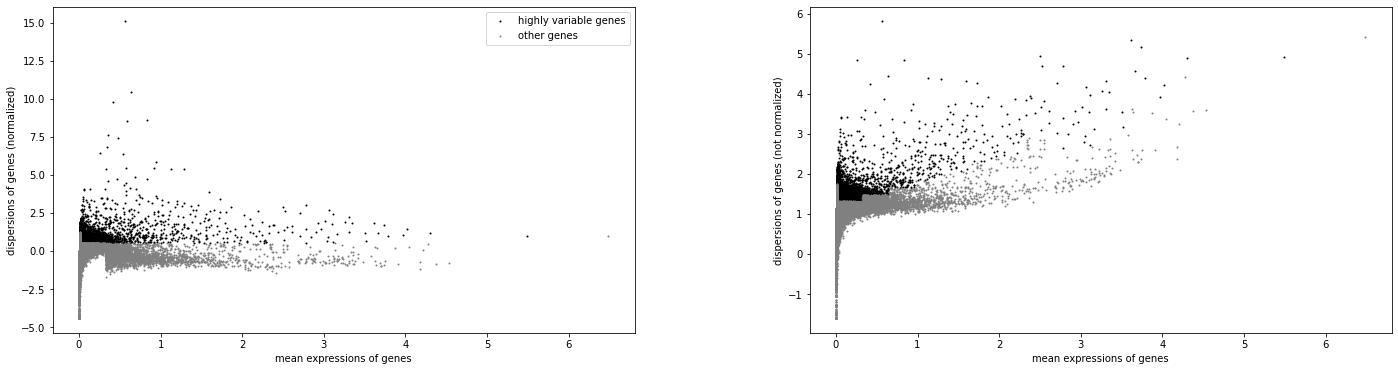

In [8]:
plt.rcParams['figure.figsize'] = [12, 6]

sc.pp.highly_variable_genes(adata_stromal, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(adata_stromal)

In [9]:
sc.pp.scale(adata_stromal, max_value=10)
sc.tl.pca(adata_stromal, svd_solver='arpack')

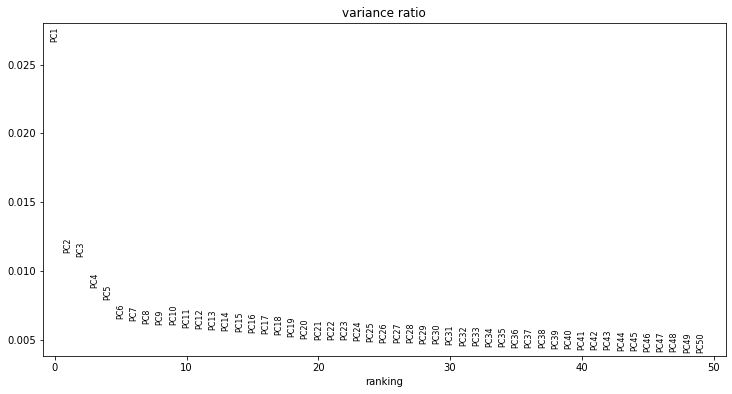

In [10]:
plt.rcParams['figure.figsize'] = [12, 6]

sc.pl.pca_variance_ratio(adata_stromal, n_pcs=50)

PC = 1


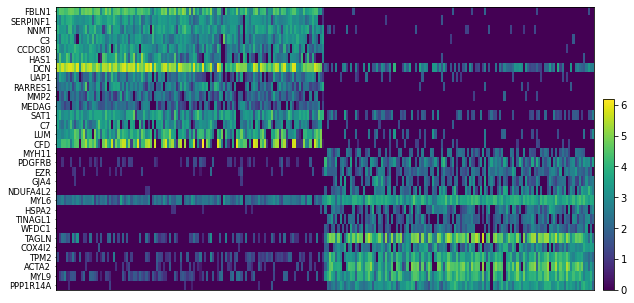

PC = 2


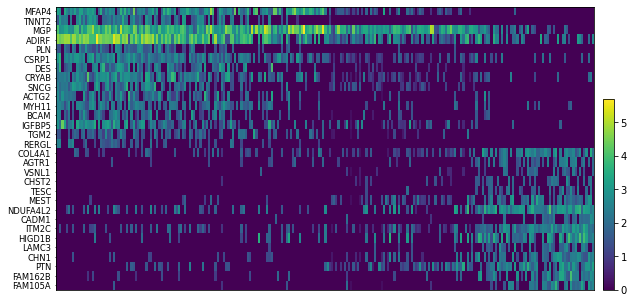

PC = 3


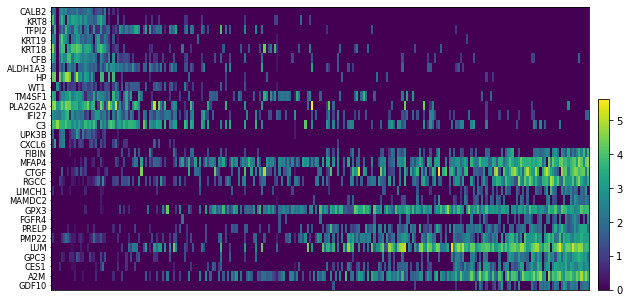

PC = 4


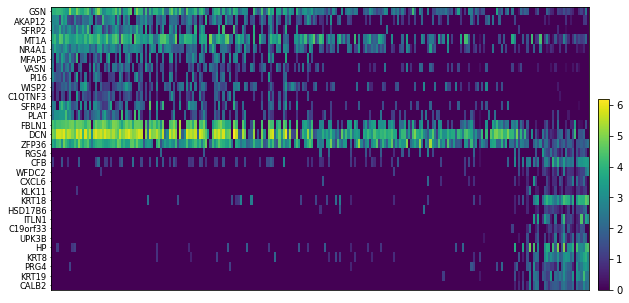

PC = 5


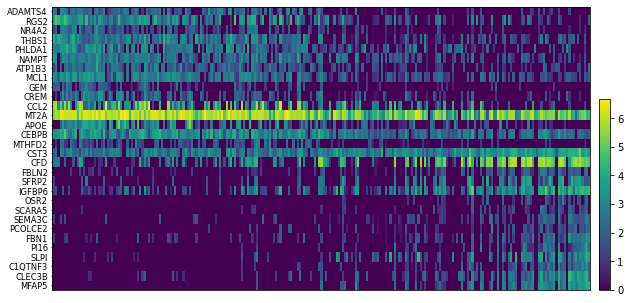

PC = 6


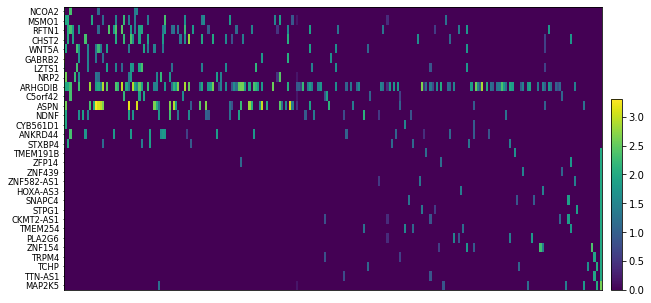

PC = 7


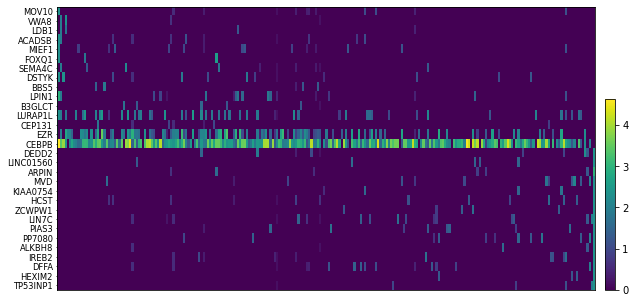

PC = 8


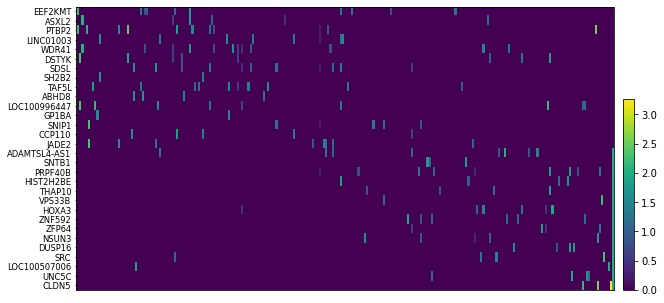

PC = 9


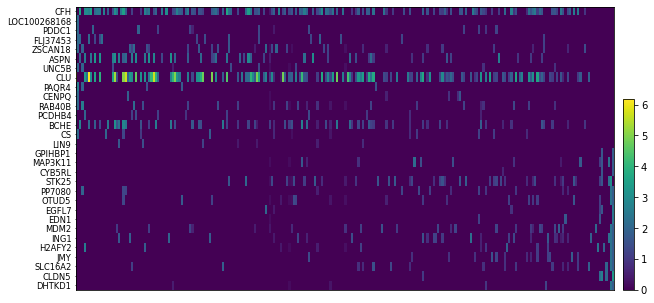

PC = 10


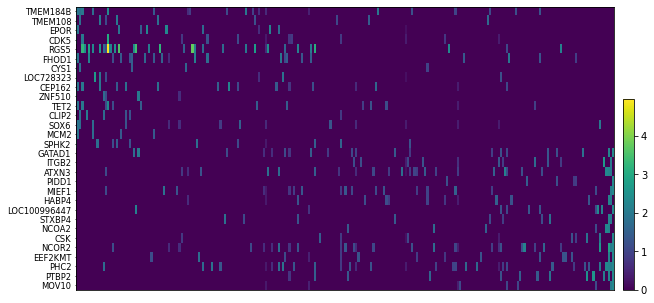

PC = 11


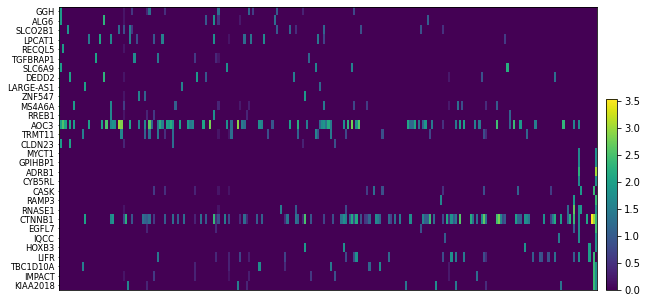

PC = 12


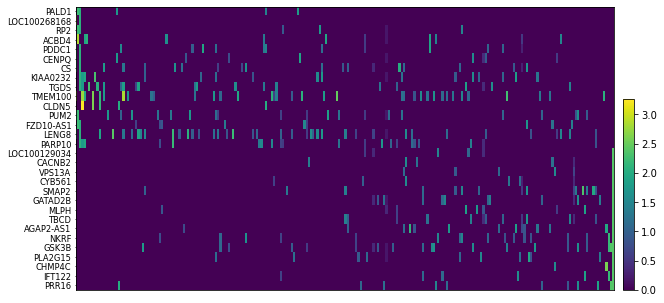

PC = 13


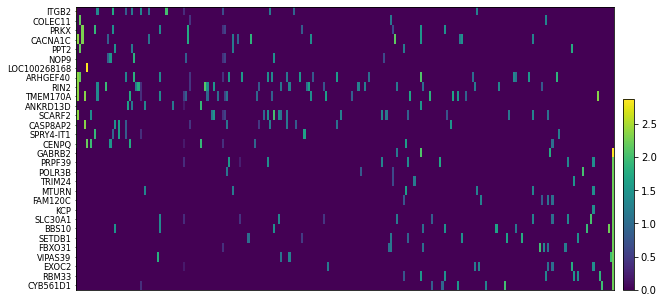

PC = 14


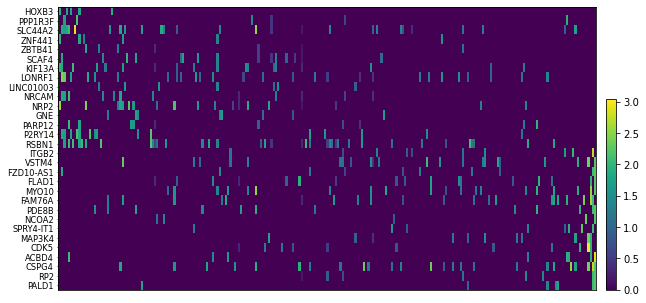

PC = 15


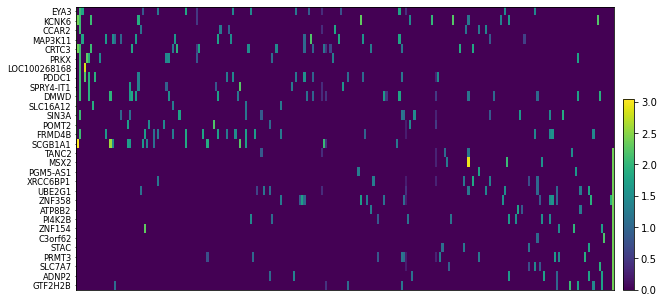

PC = 16


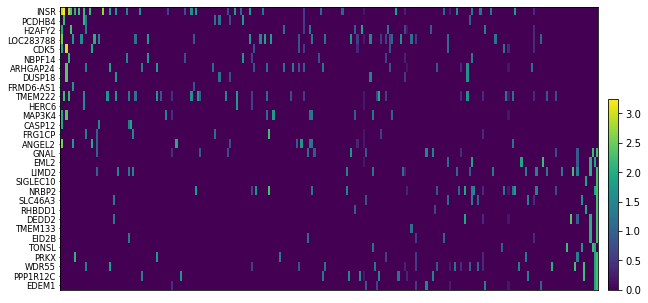

PC = 17


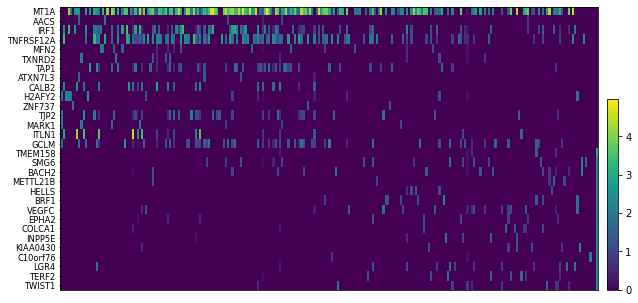

PC = 18


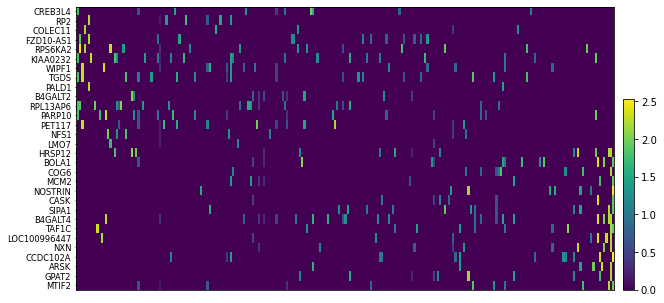

PC = 19


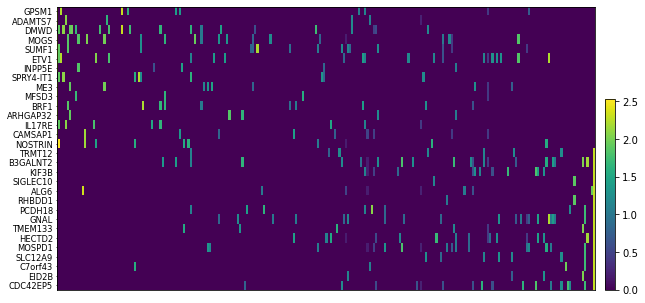

PC = 20


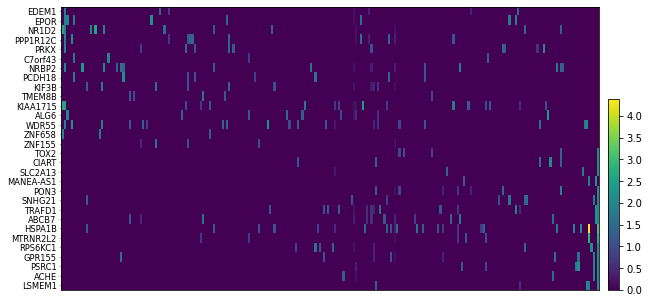

PC = 21


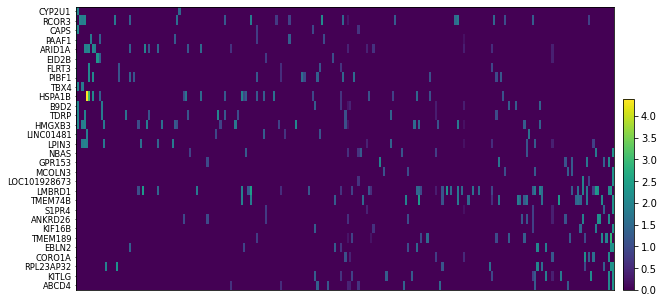

PC = 22


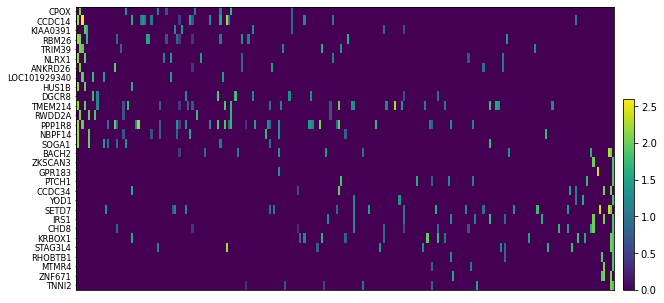

PC = 23


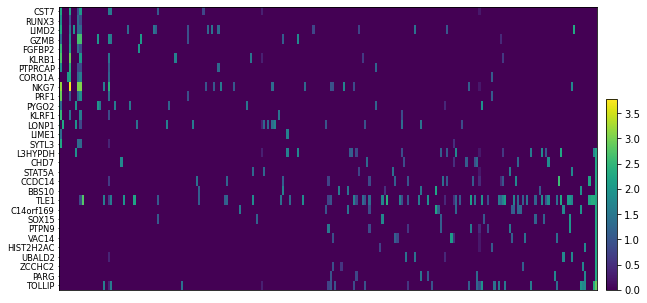

PC = 24


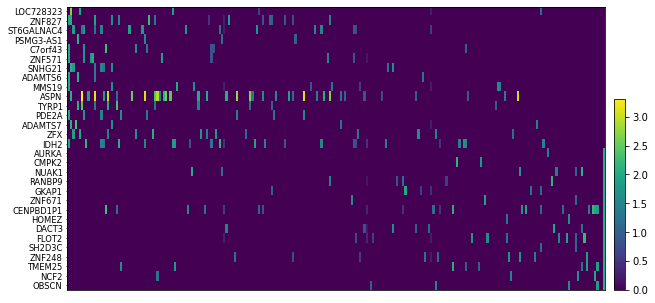

PC = 25


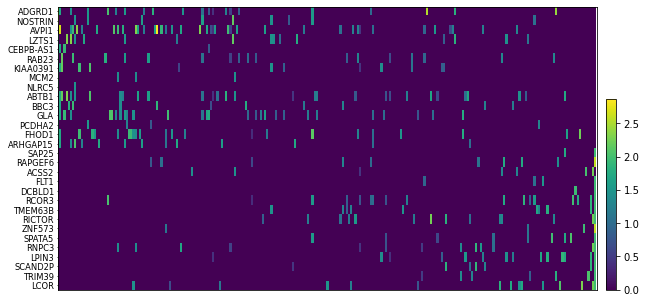

In [11]:
plt.rcParams['figure.figsize'] = [12, 25]

# Plot expression of the top and bottom 15 genes (based on loading) in each principle component
# from the 500 cells with the highest or lowest scores in that component
# Similar to Seurat's DimHeatmap() command
genes = adata_stromal.var_names.to_series()
for pc in range(1,26):
    g = adata_stromal.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:15],o[-15:])).tolist()
    emb = adata_stromal.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    cells = np.append(np.argsort(emb)[:125], np.argsort(emb)[-125:])
    tempdata = adata_stromal[cells,]
    print('PC = ' + str(pc))
    sc.pl.heatmap(tempdata, var_names=genes[sel].index.tolist(), swap_axes=True, groupby=None)

In [33]:
sc.pp.neighbors(adata_stromal, n_neighbors=20, n_pcs=18)
sc.tl.leiden(adata_stromal, resolution=0.45)

In [14]:
sc.tl.umap(adata_stromal)

In [36]:
print('Leiden vs Truth AMI: ' + str(round(sk.metrics.adjusted_mutual_info_score(adata_stromal.obs.free_annotation, adata_stromal.obs.leiden), 2)))

Leiden vs Truth AMI: 0.88


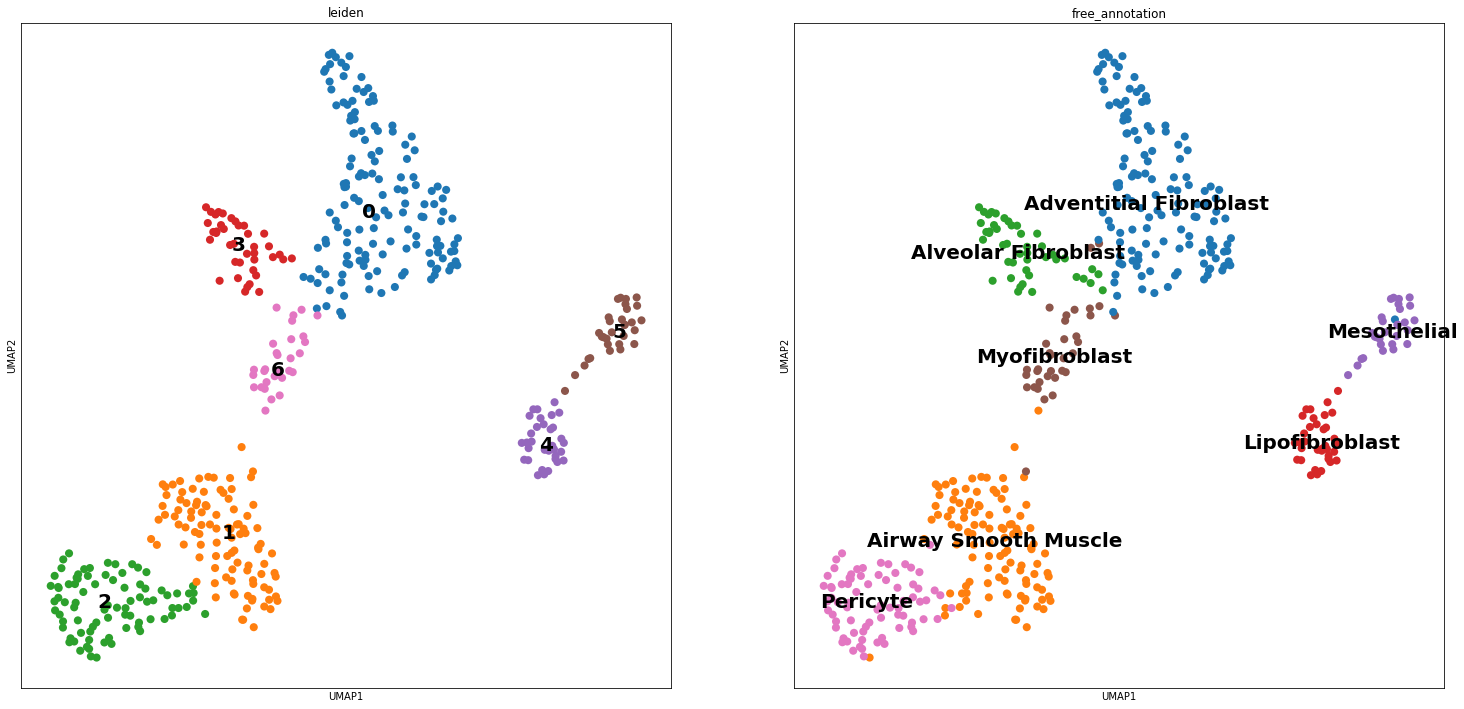

In [38]:
plt.rcParams['figure.figsize'] = [12, 12]

sc.pl.umap(adata_stromal, color=['leiden', 'free_annotation'], legend_loc='on data', legend_fontsize=20)

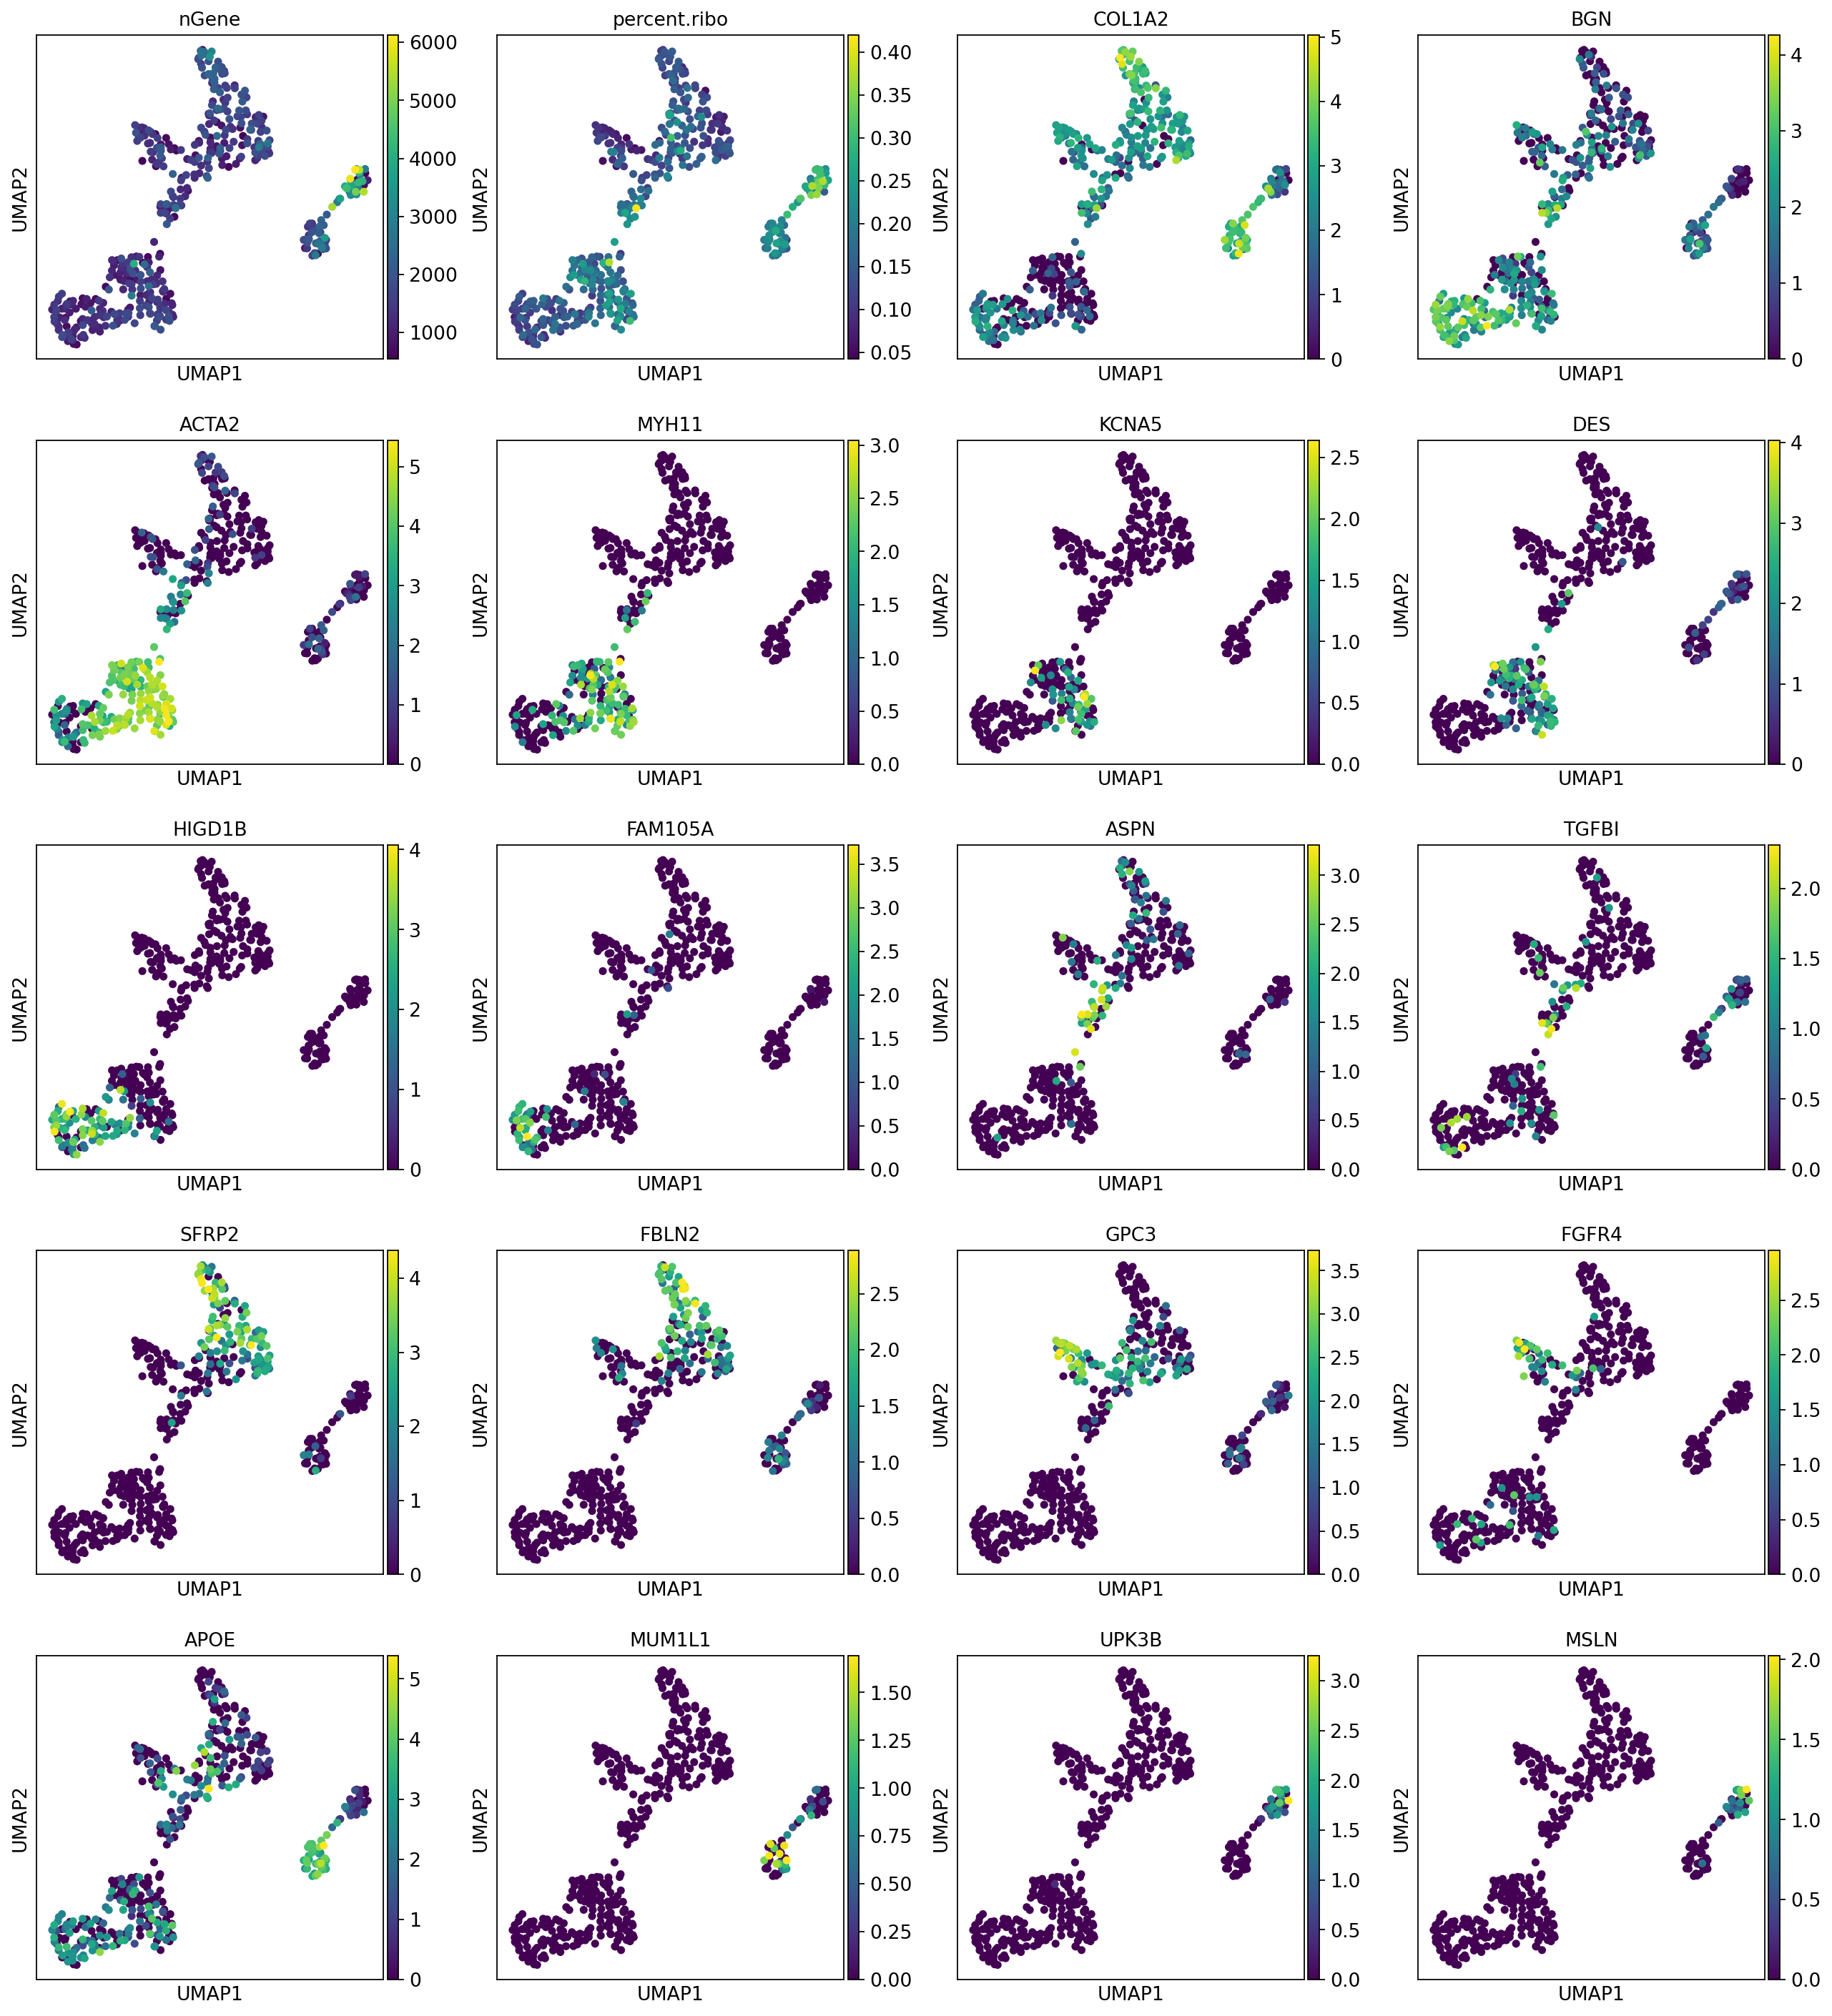

In [50]:
plt.rcParams['figure.figsize'] = [12, 12]
sc.set_figure_params(fontsize=12)

sc.pl.umap(adata_stromal,
           size=100,
           color=["nGene", "percent.ribo", # Basic QC
                  "COL1A2", "BGN", # Stromal markers
                  "ACTA2", "MYH11", # Contractile markers
                  "KCNA5", "DES", # Airway smooth muscle
                  "HIGD1B", "FAM105A", # Pericyte
                  "ASPN", 'TGFBI', # Myofibroblast
                  "SFRP2", "FBLN2", # Adventitial fibroblast
                  "GPC3", "FGFR4", # Alveolar fibroblast
                  "APOE", "MUM1L1", # Lipofibroblast
                  "UPK3B", "MSLN"]) # Mesothelial cell
           

In [51]:
sc.tl.rank_genes_groups(adata_stromal, groupby='leiden')

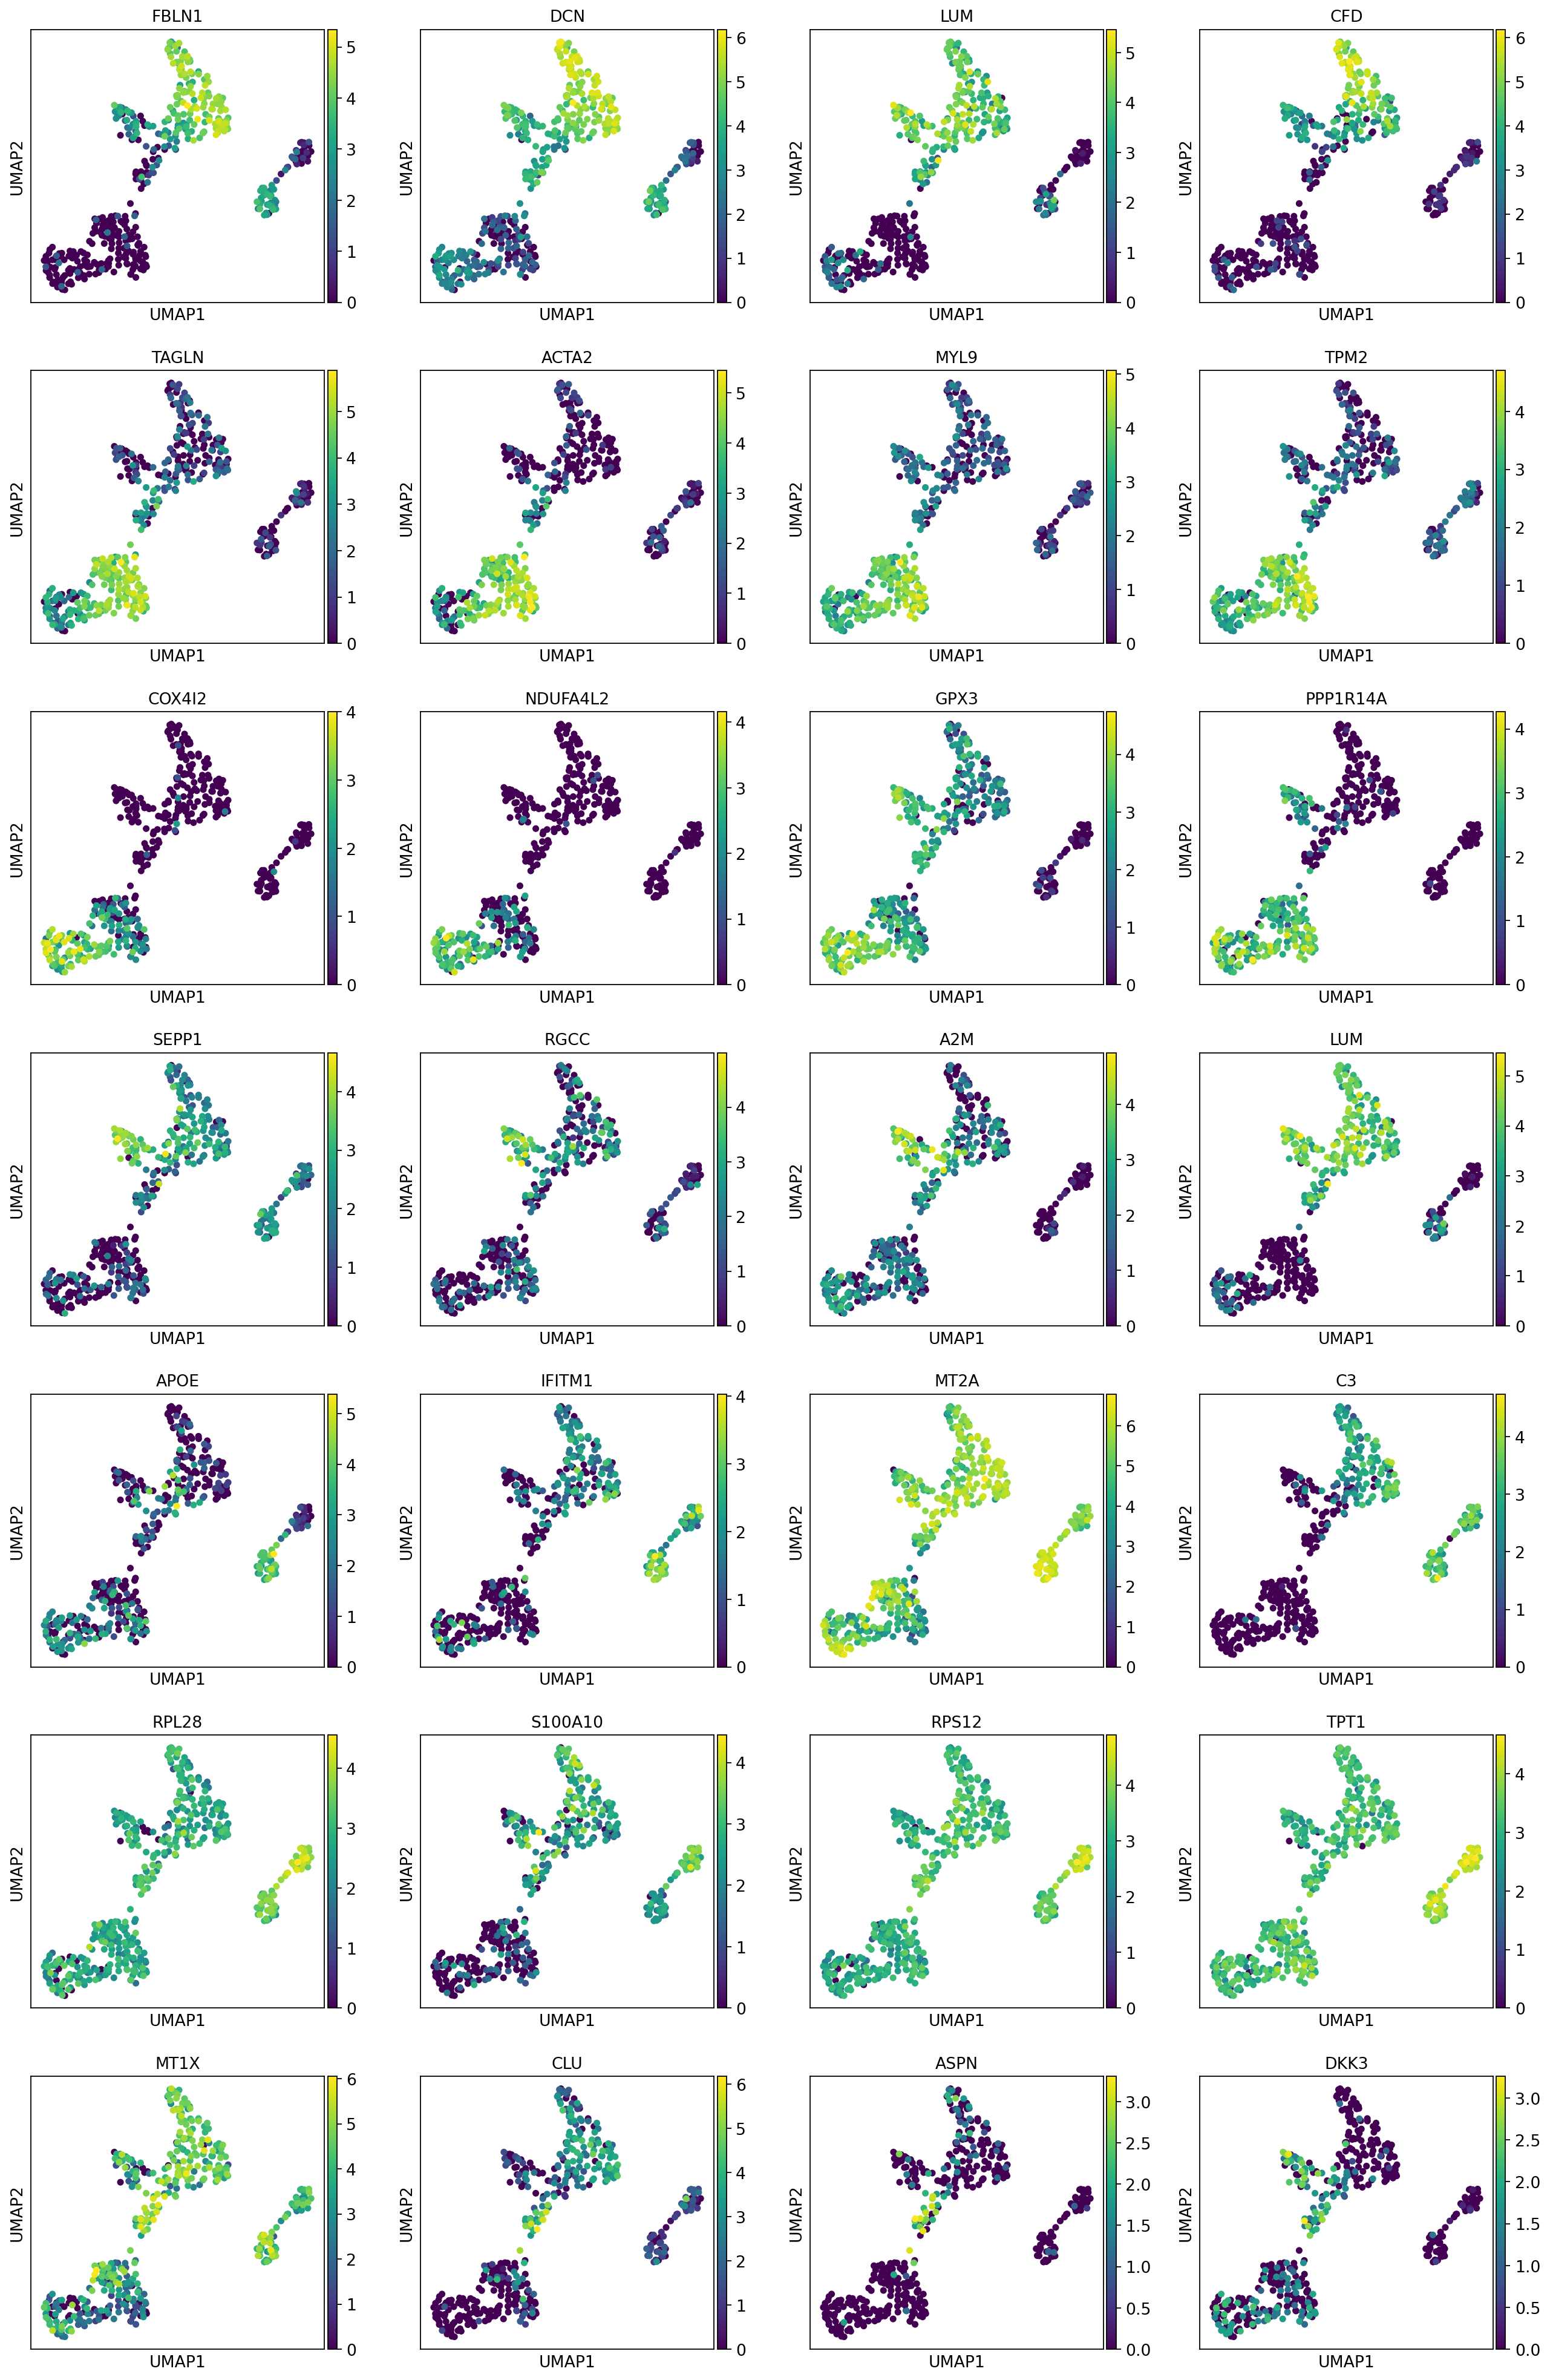

In [52]:
plt.rcParams['figure.figsize'] = [12, 12]

# Plot expression of 4 markers per cluster
sc.pl.umap(adata_stromal, color=np.ravel(np.array(pd.DataFrame(adata_stromal.uns['rank_genes_groups']['names']).head(4).T)), size=100)

... storing 'new_annotation' as categorical


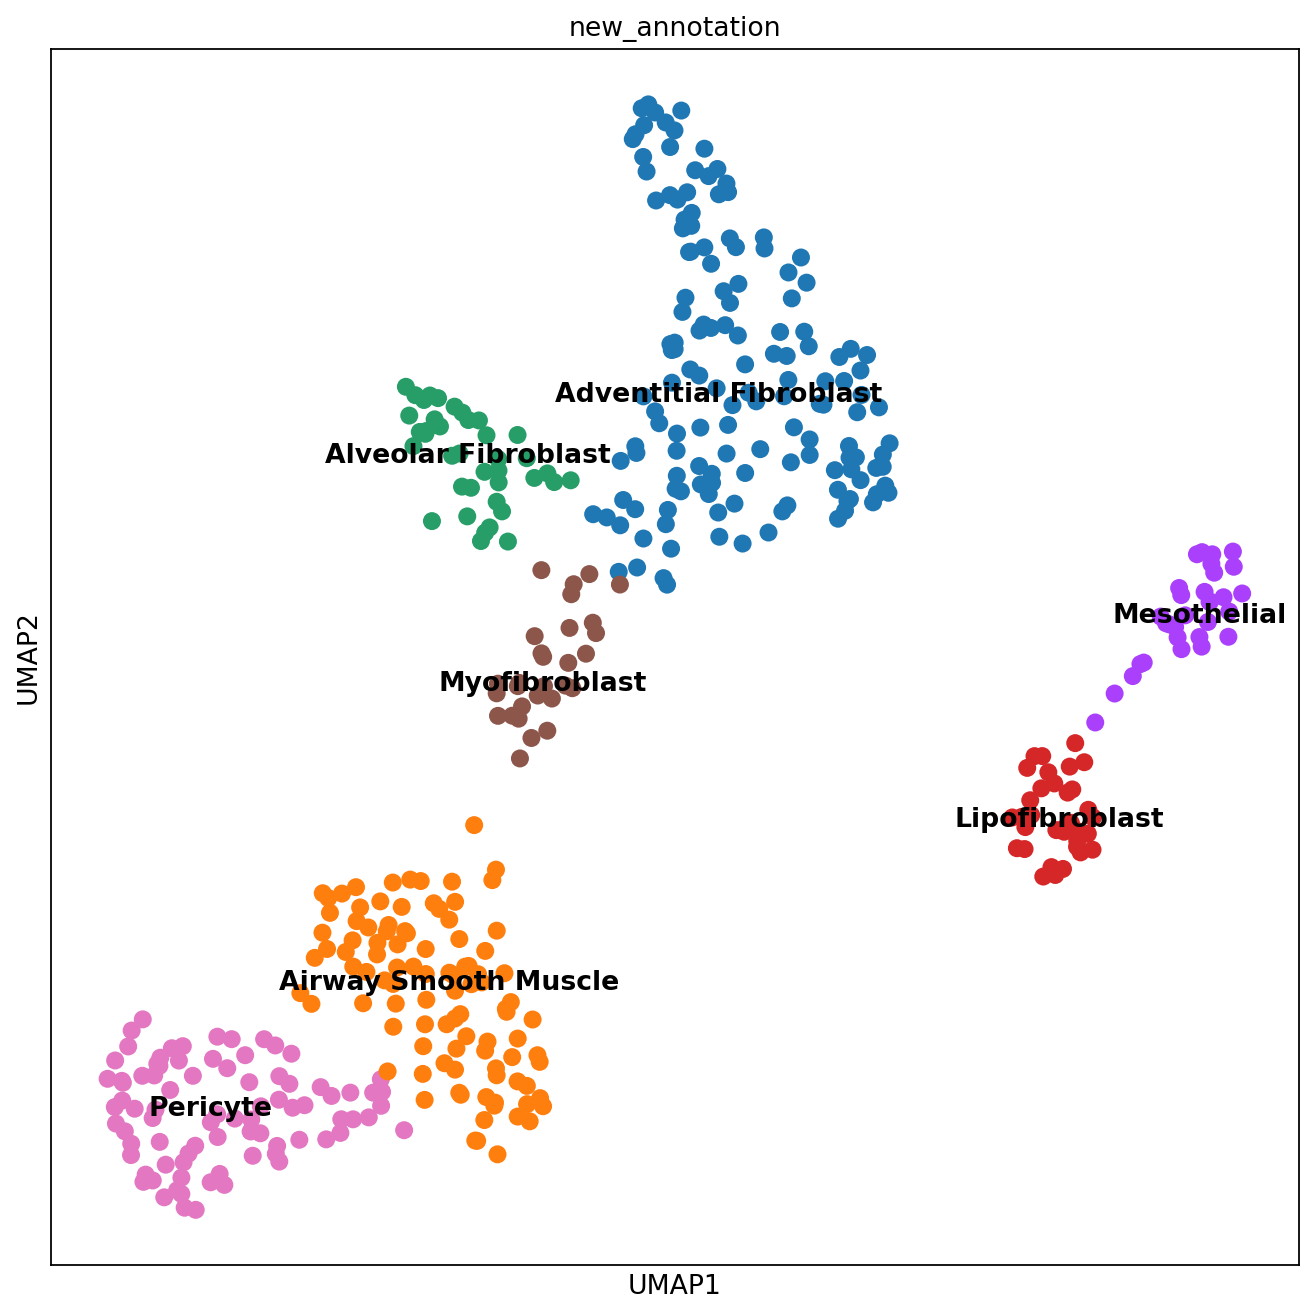

In [69]:
plt.rcParams['figure.figsize'] = [10, 10]

new_cluster_names = {
    '0': 'Adventitial Fibroblast',
    '1': 'Airway Smooth Muscle',
    '2': 'Pericyte',
    '3': 'Alveolar Fibroblast',
    '4': 'Lipofibroblast',
    '5': 'Mesothelial',
    '6': 'Myofibroblast'}
adata_stromal.obs['new_annotation'] = [new_cluster_names[x] for x in adata_stromal.obs.leiden]
sc.pl.umap(adata_stromal, color=['new_annotation'], legend_loc='on data', legend_fontsize=12)

In [73]:
tmp = adata_stromal.obs.free_annotation == adata_stromal.obs.new_annotation

In [78]:
print('% correct: ' + str(round(100 * tmp.sum() / len(tmp), 2)))

% correct: 94.32


## Integrate 10x and SS2 data using scanpy

In [95]:
adata_facs = sc.read_csv(filename=os.path.join(pwd, 'krasnow_hlca_facs_counts.csv')).T
adata_facs = adata_facs[adata_facs.obs_names.sort_values()]
tmp = pd.read_csv(filepath_or_buffer=os.path.join(pwd, 'krasnow_hlca_facs_metadata.csv'), index_col=0).sort_index()
adata_facs.obs = tmp.copy()
adata_facs = adata_facs[adata_facs.obs.patient == 1]

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [96]:
adata_facs.write(os.path.join(pwd, 'krasnow_hlca_facs_raw.h5ad'))

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'plate.barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organism' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sorter' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sort.location' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, cop

In [149]:
#adata_facs = sc.read_h5ad(os.path.join(pwd, 'krasnow_hlca_facs_raw.h5ad'))

In [97]:
adata = copy.deepcopy(adata_raw)
var_names = adata.var_names.intersection(adata_facs.var_names)
adata_ref = adata[:, var_names]
adata_facs = adata_facs[:, var_names]

In [98]:
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
adata_ref.raw = adata_ref

sc.pp.highly_variable_genes(adata_ref, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pp.scale(adata_ref, max_value=10)

sc.pp.pca(adata_ref, svd_solver='arpack')
sc.pp.neighbors(adata_ref, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_ref)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


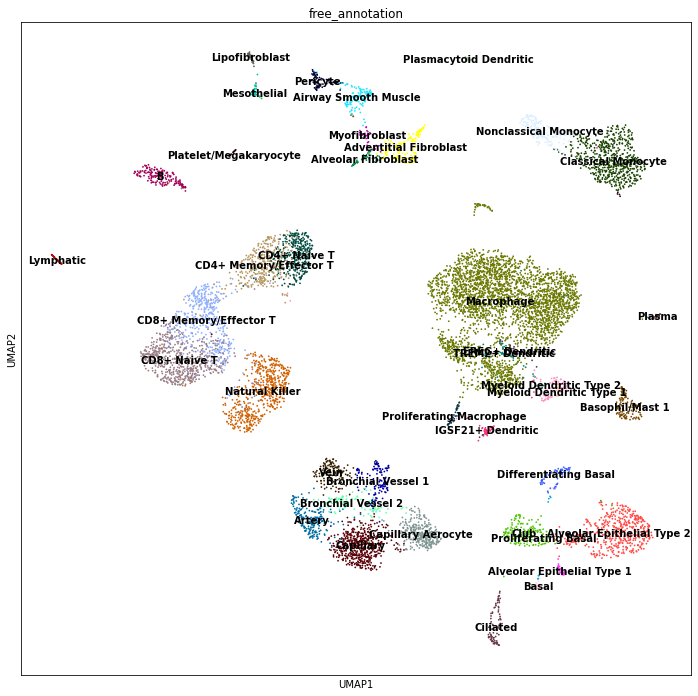

In [99]:
plt.rcParams['figure.figsize'] = [12, 12]

sc.pl.umap(adata_ref, color=['free_annotation'], legend_loc='on data', legend_fontsize=10)

In [100]:
adata_facs.obs['orig_annotation'] = adata_facs.obs.free_annotation.copy()
sc.tl.ingest(adata_facs, adata_ref, obs='free_annotation')

Trying to set attribute `.obs` of view, copying.


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


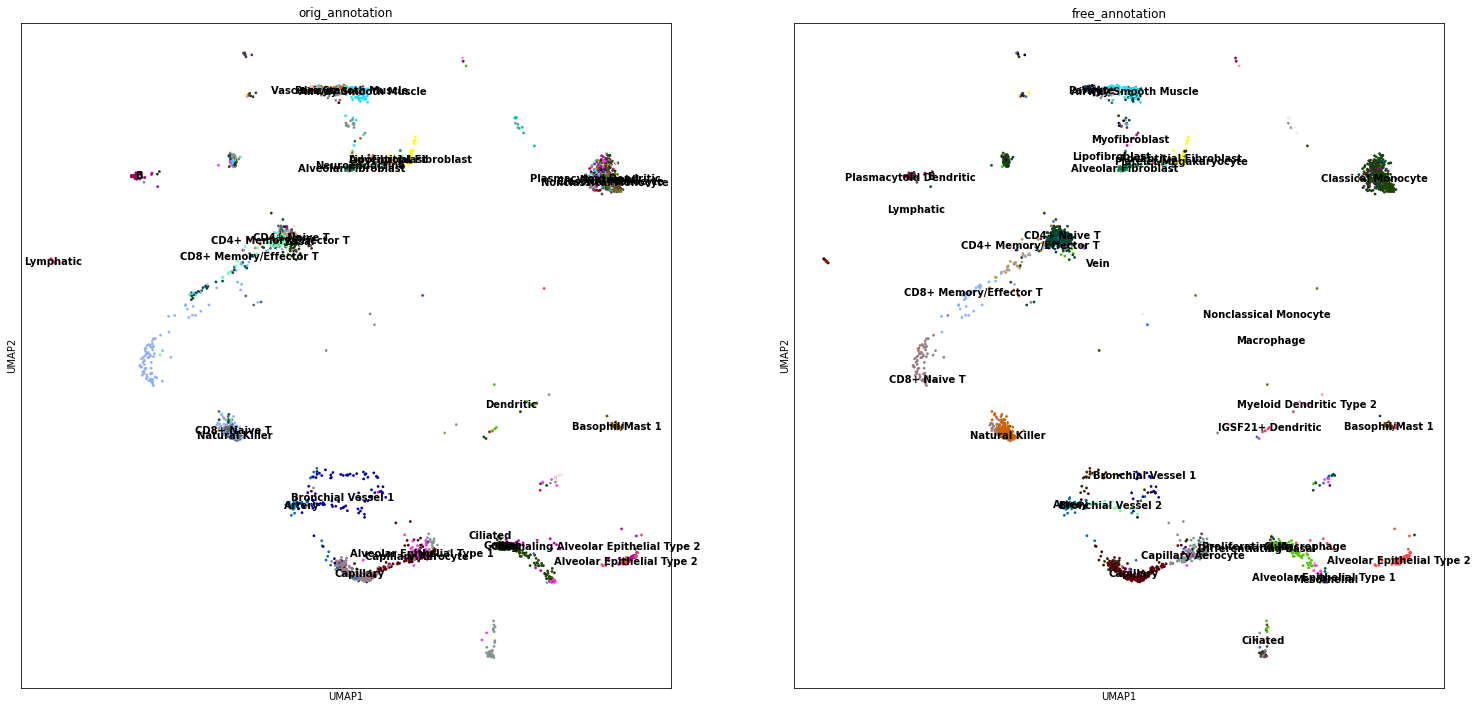

In [102]:
plt.rcParams['figure.figsize'] = [12, 12]

sc.pl.umap(adata_facs, color=['orig_annotation', 'free_annotation'], legend_loc='on data', legend_fontsize=10)

In [107]:
adata_facs.obs.orig_annotation = adata_facs.obs.orig_annotation.astype(str)
adata_facs.obs.free_annotation = adata_facs.obs.free_annotation.astype(str)
tmp = adata_facs.obs.free_annotation == adata_facs.obs.orig_annotation
print('Total % correct: ' + str(round(100 * tmp.sum() / len(tmp), 2)))

Total % correct: 54.68


In [108]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(adata_facs.obs.groupby(["orig_annotation", "free_annotation"]).size().reset_index(name="Number"))

                          orig_annotation             free_annotation  Number
0                  Adventitial Fibroblast      Adventitial Fibroblast      40
1                  Adventitial Fibroblast         Alveolar Fibroblast       2
2                  Adventitial Fibroblast          Bronchial Vessel 1       3
3                  Adventitial Fibroblast          Classical Monocyte       4
4                  Adventitial Fibroblast              Lipofibroblast       1
5                  Adventitial Fibroblast                    Pericyte       1
6                  Adventitial Fibroblast                        Vein       3
7                    Airway Smooth Muscle      Adventitial Fibroblast       1
8                    Airway Smooth Muscle        Airway Smooth Muscle     183
9                    Airway Smooth Muscle         Alveolar Fibroblast       1
10                   Airway Smooth Muscle                      Artery       4
11                   Airway Smooth Muscle                CD4+ Na

In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(adata_facs.obs.groupby(["orig_annotation"]).size().reset_index(name="Number"))

                         orig_annotation  Number
0                 Adventitial Fibroblast      54
1                   Airway Smooth Muscle     272
2             Alveolar Epithelial Type 1     101
3             Alveolar Epithelial Type 2     137
4                    Alveolar Fibroblast      80
5                                 Artery      61
6                                      B     118
7                                  Basal      24
8                        Basophil/Mast 1      25
9                     Bronchial Vessel 1     106
10                CD4+ Memory/Effector T     126
11                          CD4+ Naive T     122
12                CD8+ Memory/Effector T      59
13                          CD8+ Naive T     365
14                             Capillary     259
15                    Capillary Aerocyte     154
16                              Ciliated     196
17                    Classical Monocyte     106
18                                  Club     640
19                  

In [112]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(adata_ref.obs.groupby(["free_annotation"]).size().reset_index(name="Number"))

               free_annotation  Number
0       Adventitial Fibroblast     133
1         Airway Smooth Muscle     108
2   Alveolar Epithelial Type 1      26
3   Alveolar Epithelial Type 2     494
4          Alveolar Fibroblast      45
5                       Artery     208
6                            B     162
7                        Basal      24
8              Basophil/Mast 1     117
9           Bronchial Vessel 1     127
10          Bronchial Vessel 2     103
11      CD4+ Memory/Effector T     359
12                CD4+ Naive T     338
13      CD8+ Memory/Effector T     462
14                CD8+ Naive T     644
15                   Capillary     572
16          Capillary Aerocyte     300
17                    Ciliated      86
18          Classical Monocyte     607
19                        Club     176
20       Differentiating Basal      63
21             EREG+ Dendritic      27
22           IGSF21+ Dendritic      48
23              Lipofibroblast      35
24                   Lymp

**Question:** Looking carefully at Seurat's accuracy and what cell types exist in both datasets, why do you think it struggled and succeeded where it did?

**Answer:**